In [1]:
from IPython.core.display import HTML
css_file = './numericalmoocstyle.css'
HTML(open(css_file, "r").read())

In [2]:
import numpy
#
import math
#
import scipy
from scipy import constants
#
import matplotlib.pyplot
%matplotlib inline
#
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot, cm
#
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
#
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
# from JSAnimation import IPython_display
#
from moviepy.editor import *
# 
import timeit
import numba
from numba import jit

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [3]:
def plot(v1, v2, xlabl, ylabl, title):
    ''' a function for plots
    
    Parameters
    ----------
    v1: x-axis vector
    v2: y-axis vector
    xlabl: label for x-axis values
    ylabl: label for y-axis values
    title: plot title
    
    Return:
    -------
    Plot!
    '''
    #
    pyplot.figure(figsize=(8,8))
    pyplot.grid(True)
    #
    pyplot.xlabel(xlabl, fontsize=18)
    pyplot.ylabel(ylabl, fontsize=18)
    #
    pyplot.tick_params(axis='x', pad=10)
    pyplot.tick_params(axis='y', pad=10)
    #
    pyplot.xticks(numpy.arange(0, Lgap+0.001, 0.001))
    #
    pyplot.title(title)
    pyplot.plot(v1,v2, color='k', ls='--', lw=2, marker='o');

### Domain

In [4]:
def get_domain(Ld, n_gap):
    ''' This function obtains the domain based on a 
    staggered grid. The domain is divided into three parts:
    (1) anode region, (2) gap, (3) cathode.
    
    However the electrodes region is not modeled here and only the gap is considered
    with inlet boundary condition at the anode and an outlet boundary condition at the
    cathode
    
    Parameters:
    ----------
    Ld: Domain Length
    n_gap: number of boundary nodes in gap
    
    Returns:
    --------
    gap domain from x = 0 to x = length (this is the length of the interelectrode gap)
    '''
    #staggered grid approach
    #gap region
    xl_gap = 0.0
    xr_gap = Ld
    delx_gap = (xr_gap-xl_gap)/(n_gap-1.0)
    xb_gap = numpy.linspace(xl_gap, xr_gap, n_gap)
    xc_gap = xb_gap[:-1]+(delx_gap*0.5)
    #
    return delx_gap, xb_gap, xc_gap
    

In [5]:
# Domain, Dimensions
L_chamber = 0.24  #meters
Lgap = 0.004 #interelectrode gap [meters]
L_cathode = 0.112
L_anode = L_chamber - (Lgap + L_cathode)
#
# nx_anode = 101
# nx_cathode = 111
nx_gap = 121
#
Rc = (12.5/2.) * 1./1000. # cathode radius [meters]
Ran = 6.35/2. * 1./1000.  #anode radius [meters]

#get cell boundary and cell center locations
dx, xb, xc = get_domain(Lgap,nx_gap)
#
l2_target = 1e-7
#
#time step
dt = 1e-6 #0.000015 # {sec} time step

In [6]:
numpy.shape(xb)

(121,)

In [7]:
numpy.shape(xc)

(120,)

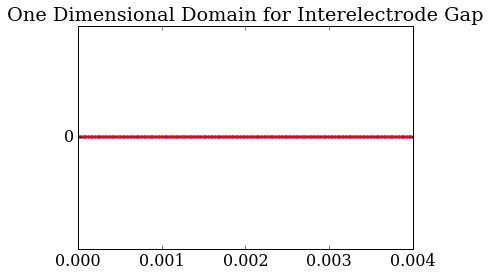

In [8]:
Xc_gap = numpy.meshgrid(xc)
Xb_gap = numpy.meshgrid(xb)
#
pyplot.title('One Dimensional Domain for Interelectrode Gap')
pyplot.ylim(-.0002,0.0002)
pyplot.xlim(0., Lgap)
pyplot.scatter(Xb_gap,numpy.zeros_like(Xb_gap),\
                   s=10, color='b', marker='o', linewidth=0)
pyplot.scatter(Xc_gap,numpy.zeros_like(Xc_gap), \
                   s=10, color='r', marker='o', linewidth=0)
pyplot.xticks(numpy.arange(0, Lgap+0.001, 0.001))
pyplot.yticks(numpy.arange(0, 0.0002, 0.001));

Note that velocities are calculated on the cell boundaries (blue), and the pressure, density,electrical conductivity, potential, current density and temperature are calculated on the cell center (red)

### Initialization

In [9]:
def L2_error(p_new, p_old):
    '''This function computes the L2 norm of the error for convergence
    
    This function is used for convergence of the pressure equation

    Parameters:
    ----------
    p_new: new computed potential in flow field
    p_old: previous flow field potential
    
    Returns:
    ----------
    L2 norm of the error
    
    '''
    return numpy.sqrt(numpy.sum((p_new[:] - p_old[:])**2)\
                      /numpy.sum(p_old[:]**2))

In [10]:
#Input Current
I_arc = 60.0

#Initialization Variables
gamma1 = 5.0/3.0
gravity = 9.81

# collision radii, set equal to van der waal radii:
RSCD_N_B = (1.55 + 1.92) #nitrogen-boron
RSCD_N_Ni = (1.55 + 1.63) #nitrogen-nickel
RSCD_N_Co = (1.55 + 1.63) #nitrogen-cobalt, note that cobalt radius not available 

#Constants
Ckb = scipy.constants.k  #Boltzmann Constant J/K
Cme = scipy.constants.m_e #Elementary Electron Mass kg
Ch = scipy.constants.h; # Planck's constant Js
CA = 1.2e6 #Richardson constant in electron current density eqn [A/(m^2 K^2)], pg.62
CNA = scipy.constants.N_A #avogadros number
Ce = scipy.constants.e #elementary charge, C

#Boron
rho_B = 2460. #kg/m3
M_B = 10.811e-3/CNA #kg, mass of 1 atom of pure boron (also = Ckb/M)
mB = 10.811 # molar mass g/mol
Ips1 = 800.6e3/CNA #J, energy of first ionization
cp_B = 1030. # J/(Kg K)
R_B = 8314.0/mB #specific gas constant
Boron_workfunction = 4.45 #eV
dH_B = 507e6/mB #heat of vaporization J/Kg
Uiz_B = 8.2980 #eV
k_B = 27. #W/(mK)

#Nickel
rho_Ni = 8908
M_Ni = 58.6934e-3/CNA #kg, mass of 1 atom of pure nickel (also = Ckb/M)
mNi = 58.6934 # molar mass g/mol
Ips2 = 737.1e3/CNA #J, energy of first ionization
cp_Ni = 445. # J/(Kg K)
R_Ni = 8314.0/mNi #specific gas constant
Nickel_workfunction = 5.01 #eV
dH_Ni = 378e6/mNi #heat of vaporization J/Kg
Uiz_Ni = 7.6398 #eV
k_Ni = 91. #W/(m K)

#Cobalt
rho_Co = 8900.
M_Co = 58.9332/CNA #kg, mass of 1 atom of pure cobalt (also = Ckb/M)
mCo = 58.9332 # molar mass g/mol
Ips3 = 760.4e3/CNA #J, energy of first ionization
cp_Co = 418.68# J/(Kg K)
R_Co = 8314.0/mCo #specific gas constant
Cobalt_workfunction = 5.0 #eV
dH_Co = 375e6/mB #heat of vaporization J/Kg
Uiz_Co = 7.8810 #eV
k_Co = 100. #W/(m K)

#Nitrogen gas
rho_N = 1.25
M_N = (2*14.0067)/CNA # kg, mass of 1 atom of Helium
mN = (2*14.0067) #molar mass, g/mol
Ipg1 = 1402.3e3/CNA; # J, energy of first ionization
R_N = 8314.0/mN #specific gas constant
cp_N = 1039. #J/Kg-K
Uiz_N = 14.5341 #eV
k_N = 0.02583 #W/(m K)
#
rho_an_max = 0.99*(rho_B) + 0.005*(rho_Ni+rho_Co)
Rs_an = 0.99*(R_B) + 0.005*(R_Ni+R_Co)
M_an = 0.99*M_B  + 0.005*(M_Ni + M_Co)
k_an = 0.99*k_B  + 0.005*(k_Ni + k_Co)
cp_an = 0.99*cp_B  + 0.005*(cp_Ni + cp_Co)
Uiz_an = 0.99*Uiz_B  + 0.005*(Uiz_Ni + Uiz_Co)
dH_an = 0.99*dH_B  + 0.005*(dH_Ni + dH_Co)
anode_workfunction = 0.99*Boron_workfunction +\
                    0.005*(Nickel_workfunction+Cobalt_workfunction) #anode material

In [11]:
def get_anode_electrical_conducvtivity(anode_temperature):
    ''' defines the electrical conductivity of the anode
    
    Assumes Material Composition:
    -----------------------------
    99% Boron
    0.05% Cobalt 
    0.005 Nickel
    '''
    Ta = anode_temperature
    #electrical resistivity Boron, ohm-meter
    aB = 1.7269349748554385e-09
    bB = -4.5251567485201381e-06
    cB = 0.0042471378183947866
    dB = -1.6901341174538911
    eB = 241.21575517119322
    fB = 2.4650015754110632
    gB =0.015565132989472215
    # curve fit formula, ohm-meter
    RB = 1e-2*(aB*(Ta**6) + bB*(Ta**5) + cB*(Ta**4) + dB*(Ta**3) +\
             eB*(Ta**2) + fB*Ta + gB)
    # Cobalt, Nickel
    RCo = 64.2*(1e-9) #at room temp
    RNi = 69.3*(1e-9), #at room temp
    #electrical conductivity, S/m
    EcondB = 1/RB
    EcondCo = 1/RCo
    EcondNi = 1/RNi
    #
    Econd_anode = 0.99*(EcondB) + 0.05(EcondCo + EcondNi)
    #
    return Econd_anode
    

In [12]:
def get_cathode_electrical_conductivity(cathode_temperature):
    '''defines electrical conductivity of cathode
    
    Assumes:
    --------
    Material 100% Tungsten
    '''
    Tc = cathode_temperature
    # coefficients for resistivity curve fit
    aT = 2.1944927729132266e-17
    bT = 7.312046623503785e-14
    cT = 3.6788309037808543e-10
    dT = -6.1212828933518841e-08
    # resistivity, ohm-meter
    RT = aT*(Tc**3) + bT*(Tc**2) + cT*(Tc) + dT
    # electrical conductivity, S/m:
    econdT = 1/RT
    #
    return econdT

##### Initial Conditions

In [13]:
def get_initial_conditions(x1,x2,I_input,R_anode):
    '''
    - Defines initial arrays
    - Adds two ghost cells to represent nodes on anode and cathode,
        for boundary conditions
    
    Parameters:
    -----------
    x1: boundary x locations
    x2: center cell x locations
    I_input: arc current input
    R_anode: anode radius
    
    Returns:
    -------
    Arrays!
    Tx: temperature 
    jx: current density
    phix: electric potential
    cpx: specific heat
    visc: viscosity (mu)
    ux: velocity
    kx: thermal conductivity
    rhox: density
    Px: pressure
    hx: enthalpy
    econdx: electrical conductivity
    nex: number density of electrons
    
    Consistent with the staggered grid approach, the velocity is calculated on the
    cell boundaries and all of the other values are computed on the cell centers.
    '''
    Tref = 300.0 # initial reference temperature
    #
    a = numpy.size(x1) + 2 #this is to add ghost cells, these are boundary cells
    b = numpy.size(x2) + 2 #this is to add ghost cells, these are center cells
    #-------------------------------------------------------------------------
    #initialize arrays
    #grid 1 (cell edges)
    ux = numpy.zeros((a),dtype=float) #velocity
    #grid 2 cell centers-----------------------
    jx = numpy.zeros((b), dtype=float) #current density
    phix = numpy.zeros((b),dtype=float) #electric potential
    econdx = numpy.zeros((b),dtype=float) #electrical conductivity
    rhox = numpy.zeros((b),dtype=float) #density
    nex = numpy.zeros((b), dtype=float) #number density of electrons
    #
    cpx = numpy.zeros((b),dtype=float) #specific heat
    Tx = numpy.zeros((b),dtype=float) #temperature
    visc = numpy.zeros((b),dtype=float) #viscosity
    kx = numpy.zeros((b),dtype=float) #thermal conductivity
    Px = numpy.zeros((b),dtype=float) # pressure
    hx = numpy.zeros((b),dtype=float) #enthalpy
    Rs = numpy.zeros((b),dtype=float) # specific gas constant
    #-------------------------------------------------------------------------
    jx[:] = I_input/(numpy.pi*(R_anode**2)) #current density 
    # electric potential
    phix[:] = 0.0
    # specific heat
    cpx[1:] = cp_N #J/(kg-K) of helium
    cpx[0] = cp_an
    # temperature
    Tx[:] = Tref #kelvin # assume uniform temperature
    # viscosity
    visc[:] = 1.76e-6 #of Nitrogen Pa·s = kg/(s·m)
    # velocity, assume still
    ux[:] = 0. # m/s
    # thermal conductivity
    kx[1:] = 0.02583  # W/(m-K)
    kx[0] = k_an
    # electrical conductivity
    econdx[:] = I_input # Siemens/meter
    # number density of electrons
    nex[:] = 1e6 # 1/m3, number density of electrons
    # density
    rhox[0] = 1.251 #nitrogen, this is anode material but set as nitrogen to start
    rhox[1:] = 1.251 #nitrogen
    #
    Px[:] = (rhox[:])*R_N*Tx[:] + (nex[:])*Ckb*Tx[:] #50662.5 #
    #
    return Tx, jx, phix, cpx,visc, ux, kx, rhox, Px, hx, econdx, nex

In [14]:
T0,j0,phi0,cp0,mu0,u0,\
k0,rho0,p0,h0,econd0,ne0 = get_initial_conditions(xb,xc,I_arc,Ran)

In [15]:
cp0[:10]

array([ 1024.0184,  1039.    ,  1039.    ,  1039.    ,  1039.    ,
        1039.    ,  1039.    ,  1039.    ,  1039.    ,  1039.    ])

In [16]:
econd0[:10] 
# this is how the electrical conductivity is initialized (same as arc current)

array([ 60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.])

In [17]:
j0[:10] 
#this is the initial condition for current density (corresponfs to 60 amps everywhere)

array([ 1894584.23173439,  1894584.23173439,  1894584.23173439,
        1894584.23173439,  1894584.23173439,  1894584.23173439,
        1894584.23173439,  1894584.23173439,  1894584.23173439,
        1894584.23173439])

In [18]:
h0[:10]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [19]:
rho0[:10]

array([ 1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251])

In [20]:
T0[:10]

array([ 300.,  300.,  300.,  300.,  300.,  300.,  300.,  300.,  300.,  300.])

In [21]:
p0[:10]

array([ 111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305])

## these values correspond to time n = 0

##### reference values

In [22]:
# reference values are stored (n-1) time step,
# because they are used in the energy equation 
pref = p0.copy()
Tref = T0.copy()
numx = numpy.size(p0) #number of center nodes with ghost cells

##### potential algorithm

In [23]:
def potential_algorithm(current_density,electrical_conductivity,electric_potential,\
                        center_nodes, delx):
    ''' Defines the electric potential field.
    
    This function obtains the electric potential based on two solutions to the 
    ordinary differential equation.
    
    Solution 1: B^2 - 4AC = 0
    Solution 2: B^2 - 4AC > 0
    
    Parameters
    ----------
    current_density: current density in the domain, constant current is assumed
    electrical_conductivity: 
    electric_potential: electric potential is solved from d/dx{-econd d/dx(phi)} = 0
    center_nodes: cell-center nodes are used to solve electric potential
    delx: x-direction spacing
    
    Returns:
    --------
    electric potential
    '''
    jx = current_density.copy()
    #
    xc_nodes = center_nodes.copy()
    x_an = xc_nodes[0] - 0.5*delx
    x_cath = xc_nodes[-1] + 0.5*delx
    #
    array_size = electrical_conductivity.size
    eratio = numpy.zeros_like(center_nodes)
    #
    A = numpy.zeros_like(electrical_conductivity)
    B = numpy.zeros_like(electrical_conductivity)
    #
    C1 = numpy.zeros_like(electrical_conductivity)
    C2 = numpy.zeros_like(electrical_conductivity)
    #
    econdx = electrical_conductivity.copy()
    phix = electric_potential.copy()
    #
    jx_anode = I_arc/(numpy.pi*(Ran**2)) 
    econdx_anode = 1e5 #electrical conductivity max
    anode_potential = jx_anode*delx/econdx_anode
    #
    cathode_potential =  -1.
    #
    A[1:-1] =  - econdx[1:-1]
    B[1:-1] = - (0.5/delx)*(econdx[2:] - econdx[:-2])
    #
    for i in range(1,array_size-1):
        if (B[i]**2 == 0.0 ):
            # general solution constants
            C2[i] = (cathode_potential/(numpy.exp((-B[i]/A[i])*x_cath)) -\
                     anode_potential)/(x_cath-x_an)
            C1[i] = (anode_potential/(numpy.exp((-B[i]/A[i])*x_an))) -\
                     anode_potential
            # potential solution
            phix[i] = C1[i]*numpy.exp((-B[i]/A[i])*xc_nodes[i-1]) +\
                      C2[i]*xc_nodes[i-1]*numpy.exp((-B[i]/A[i])*xc_nodes[i-1])
        if (B[i]**2 > 0.0):
            #print('using {B**2 > 0} solution for potential')
            eratio[:] = numpy.exp((-B[i]/A[i])*x_cath)/numpy.exp((-B[i]/A[i])*x_an)
            C2[i] = (cathode_potential - anode_potential*eratio[i-1])/(1.-eratio[i-1])
            C1[i] = (anode_potential-C2[i])/numpy.exp((-B[i]/A[i])*x_an)
            #potential solution
            phix[i] = C1[i]*numpy.exp((-B[i]/A[i])*xc_nodes[i-1]) + C2[i]
    #
    phix[0] = jx_anode*delx/econdx_anode
    phix[-1] = cathode_potential
    #
    return phix

In [24]:
phi_init=  potential_algorithm(j0.copy(),econd0.copy(), phi0.copy(), xc.copy(), dx)

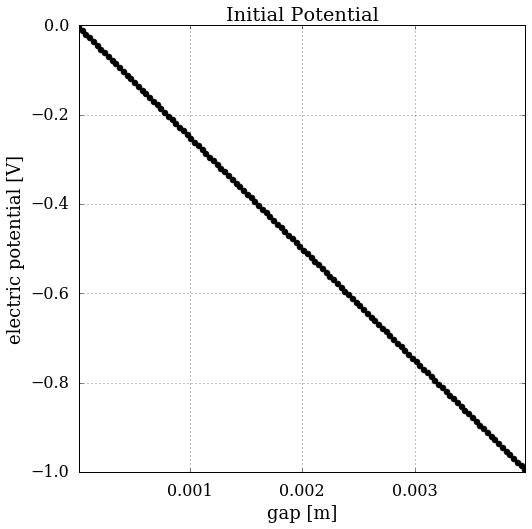

In [25]:
plot(xc, phi_init[1:-1], 'gap [m]', 'electric potential [V]', 'Initial Potential')

##### Get Temperature after Initializing Arc

## all of these values below correspond to time n = 1, until we reach then next energy function

In [26]:
def get_energy_initial(density, pressure, velocity, current_density, thermal_conductivity,\
               electrical_conductivity, specific_heat, delx, delt, reference_pressure,\
               enthalpy, reference_temperature, electron_density_anode):
    ''' Defines initial energy in the gap.
    
    The energy equation includes joule heating terms, heat flux, pressure flux, and
    momentum flux d(puh)/dx
    
    Note that this actually solves for (rho*h)
    h = (rho*h)\rho
    T = (h-href)/cp + T_{ref}
    
    Parameters:
    ----------
    enthalpy: this is the reference enthalpy
    
    Returns:
    --------
    Temperature at next time step
    '''
    ne_an = electron_density_anode
    T_ref = reference_temperature.copy()
    #
    Hflux = numpy.zeros_like(enthalpy) #heat flux
    Jflux = numpy.zeros_like(enthalpy) #joule heating
    Pflux = numpy.zeros_like(enthalpy) # pressure flux
    Mflux  = numpy.zeros_like(enthalpy) #momentum flux
    #
    rhoh = numpy.zeros_like(enthalpy) #density*enthalpy
    dTemp = numpy.zeros_like(enthalpy) # delta Temp
    h_new = numpy.zeros_like(enthalpy) #enthalpy
    T_new = numpy.zeros_like(enthalpy) #temperature
    #
    ux = velocity.copy()
    ux_int = numpy.zeros_like(enthalpy) #interpolated velocities
    ux_int[:] = 0.5*(ux[1:]+ux[:-1])
    
    P_ref = reference_pressure.copy()
    Px = pressure.copy()
    hx = enthalpy.copy() #this would be the reference enthalpy 
    rhox = density.copy()
    kx = thermal_conductivity.copy()
    cpx = specific_heat.copy()
    #
    dTemp[:] = hx[:]/cpx[:] #enthalpy/specific_heat = delta Temp
    econd = electrical_conductivity.copy()
    jx = current_density.copy()
    # joule heating flux
    Jflux[1:-1] = delt*((jx[1:-1]**2)/econd[1:-1])+\
                    delt*((5./2.)*Ckb/Ce)*(jx[1:-1])*\
                    (0.5/delx)*(dTemp[2:] - dTemp[:-2])
    # conductive heat flux
    Hflux[1:-1] = delt*(kx[1:-1]/(delx**2))*(dTemp[2:] - 2*dTemp[1:-1] + dTemp[:-2]) 
    # pressure flux
    Pflux[1:-1] = (Px[1:-1]-P_ref[1:-1]) +\
                    (0.5*delt/delx)*(Px[2:]-Px[:-2])*ux_int[1:-1]
    # convective heat flux, or momentum flux
    Mflux[1:-1] = - (0.5*delt/delx)*\
                  (rhox[2:]*ux_int[2:]*hx[2:] -rhox[:-2]*ux_int[:-2]*hx[:-2])
    # for time n+1, so rhoh_{n+1}
    rhoh[1:-1] = rhox[1:-1]*hx[1:-1] + Mflux[1:-1] + Pflux[1:-1] +\
                                                            Hflux[1:-1] + Jflux[1:-1]
    #
    h_new[1:-1] = rhoh[1:-1]/(rhox[1:-1])
    h_new[0] = h_new[1]
    h_new[-1] = h_new[-2]
    #
    #T_new[1:-1] = ((h_new[1:-1]-hx[1:-1])/cpx[1:-1]) + T_ref[1:-1]
    T_new[1:-1] = ((h_new[1:-1])/cpx[1:-1]) + T_ref[1:-1]
    #
    #boundary conditions     
    Uiz = Uiz_an # ionization energy carbon eV
    # anode region
    Tev_an = T_new[1]/(11604.52500617)
    jth = 0.25*Ce*(ne_an)*(numpy.sqrt((8*Ce*Tev_an)/(numpy.pi*Cme))) #random electron current
    # Anode Sheath drop:
    Ua_eV = - Tev_an*numpy.log(jth/numpy.abs(jx[0])) #anode potential drop
    qa = jx[0]*(2*Tev_an+ anode_workfunction + Ua_eV) # anode heat flux
    #cathode region
    Tev_cath = T_new[-2]/(11604.52500617) #convert from Kelvin to eV
    je = CA*(Tev_cath**2)*\
            numpy.exp(-anode_workfunction /(Ckb*Tev_cath)) #thermo-ionic current density
    qc = jx[-1]*(Uiz + anode_workfunction) - je*anode_workfunction #cathode heat flux
    #
    k_anode = k_an # thermal conductivity of anode(W/m K)
    k_gas = k_N
    T_new[0] = T_new[1] + (qa*delx)/k_anode #anode temperature
    T_new[-1] = T_new[-2] + (qc*delx)/k_anode #T_new[-2]  # 
    #
    return T_new
    

In [27]:
Tn = get_energy_initial(rho0.copy(), p0.copy(), u0.copy(), j0.copy(), k0.copy(),\
               econd0.copy(), cp0.copy(), dx, dt, pref.copy(),\
              h0.copy(), Tref.copy(), ne0[1])


In [28]:
Tn # this is the temperature {K} at the next time step t = 0 

array([ 358.61426233,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605258,
        346.02605258,  346.02605258,  346.02605258,  346.02605

In [29]:
Tref2 = Tn.copy()

#### This is the temperature distribution used to initialize. Note that this will vary depending on the time step

##### Thermophysical Properties

In [30]:
def get_thermophysical_properties(temperature,concentration1,concentration2,\
                                 concentration3,concentration4):
    '''finds viscosity, thermal conductivity
    
    Parameters:
    -----------
    mu: viscosity
    kth: thermal conductivity
    '''
    cs1 = concentration1 #nitrogen
    cs2 = concentration2 #boron
    cs3 = concentration3 #nickel
    cs4 = concentration4 #cobalt
    #
    mu = numpy.zeros_like(temperature) #viscosity
    mus1 = numpy.zeros_like(temperature)
    mus2 = numpy.zeros_like(temperature)
    mus3 = numpy.zeros_like(temperature)
    mus4 = numpy.zeros_like(temperature) 
    #
    kth = numpy.zeros_like(temperature) #thermal conductivity
    ks1 = numpy.zeros_like(temperature) #thermal conductivity s1
    ks2 = numpy.zeros_like(temperature) #thermal conductivity s2
    ks3 = numpy.zeros_like(temperature) #thermal conductivity s3
    ks4 = numpy.zeros_like(temperature) #thermal conductivity s4
    #
    Tx = temperature.copy() # temperature
    a = numpy.size(Tx)
    #
    #--------thermal conductivity---------
    #conductivity of Nitrogen
    aN4,bN4 = 1.1973364764750705e-11,-1.0022238377799794e-07 
    cN4,dN4,eN4 = 0.00025655111953739039,-0.1423732005907308,33.464978104210182
    ks1[:] = 1e-3*(aN4*(Tx[:]**4) + bN4*(Tx[:]**3) +\
                   cN4*(Tx[:]**2) + dN4*Tx[:] + eN4)
    #conductivity of Boron
    ks2[:] = k_B
    #conductivity of Nickel
    ks3[:] = k_Ni
    #conductivity of Cobalt
    ks4[:] = k_Co
    # total viscosity
    kth[:] = cs1[:]*ks1[:] + cs2[:]*ks2[:] + cs3[:]*ks3[:] + cs4[:]*ks4[:] 
    kth[0] = k_an
    kth[-1] = k_an 
    #
    #--------dynamic viscosity------------------
    #viscosity of nitrogen
    aNmu,bNmu = 4.2177299011972125e-09, -4.8160156609647342e-05
    cNmu,dNmu = 0.40073205811284623, 44.208627576799387
    mus1[:] = 1e-7*(aNmu*(Tx[:]**3) + bNmu*(Tx[:]**2) + cNmu*(Tx[:]) + dNmu)
    #viscosity of boron (gas)
    mus2[:] = 5.4e-5 #viscosity used in carbon-helium simulation #1e-5 #2e-3
    #viscosity of nickel (gas)
    mus3[:] = 0.
    #viscosity of viscosity (gas)
    mus4[:] = 0.
    #total viscosity
    mu[:] = cs1[:]*mus1[:] + cs2[:]*mus2[:] + cs3[:]*mus3[:] + cs4[:]*mus4[:]
    #mu[0] = 0.99*mus2[0] + 0.005*(mus3[0]+mus4[0])
    #mu[-1] = 0.99*mus2[-1] + 0.005*(mus3[-1]+mus4[-1])
    #
    return kth,mu

In [31]:
#kn, mun = get_thermophysical_properties(Tn.copy())

In [32]:
#kn[:10]

In [33]:
#mun[:10]

##### Ablation of Anode

In [34]:
def get_ablation(anode_temperature, molecular_weight):
    '''Defines ablation rate in { kg } / { m2 s }
    
    Parameters:
    -----------
    anode temperature
    molecular weight of anode material
    
    Returns:
    --------
    ablation rate
    vapor density
    '''
    Tan = anode_temperature
    A = 15.73
    B = 40030.0
    #
    MW = molecular_weight
    #
    p_vapor = (0.133*numpy.exp(2.3*(A - B/Tan)))
    ablation = p_vapor*numpy.sqrt(MW/(2*numpy.pi*Ckb*Tan))
    rho_vapor = p_vapor/(Rs_an*Tan)
    #
    #vapor density cannot exceed density of solid anode material:
#     if (rho_vapor>rho_an_max):
#         rho_vapor = rho_an_max
    #
    return ablation, rho_vapor

In [35]:
ABL, rhov = get_ablation(Tn[0],M_an)

In [36]:
rhov # vapor density in { kg } / { m3 }

7.9502845309500649e-103

In [37]:
ABL # ablation rate in { kg } / { m2 s }

8.7840621046552477e-100

##### update density boundary conditions to include the ablated density

In [38]:
def get_initial_concentrations(density, ablated_density):
    ''' defines initial concentrations for individual species in the domain
    
    Parameters:
    -----------
    density: total density in the domain
    ablated_density: vapor density obtained from vapor pressure
    
    Returns:
    -------
    c_B: concentration of boron species
    c_Ni: concentration of nickel species
    c_Co: concentration of cobalt species
    c_N: concentration of nitrogen species
    '''
    rhox = density.copy()
    #
    c_B = numpy.zeros_like(density)
    c_Ni = numpy.zeros_like(density)
    c_Co = numpy.zeros_like(density)
    c_N = numpy.zeros_like(density)
    #Concentration of boron
    c_B[1:] = 0.99*ablated_density/(rhox[1:])
    c_B[0] = 0.99
    #nickel
    c_Ni[1:] = 0.005*ablated_density/(rhox[1:])
    c_Ni[0] = 0.005
    #cobalt
    c_Co[1:] = 0.005*ablated_density/(rhox[1:])
    c_Co[0] = 0.005
    # concentration of helium
    c_N[1:] = (rhox[1:]-ablated_density)/rhox[1:]
    c_N[0] = 1.-c_B[0]-c_Ni[0]-c_Co[0]
    #
    return c_B, c_Ni, c_Co, c_N

In [39]:
def density_bc(density, ablated_density):
    ''' updates densities in the anode region 
        by summing ablated density with local density
    
    Parameters:
    -----------
    density: total density in the domain
    ablated_density: vapor density obtained from vapor pressure
    
    Returns:
    -------
    density with updated boundary values
        
    '''
    rhobc = density.copy()
    local_density = rhobc[1]
    rho_ablated = ablated_density
    #
    rhobc[-1] = rhobc[-2]
    #
    if (rho_ablated < local_density):
        rhobc[0] = rho_ablated+local_density
    else:
        rhobc[0] = rho_ablated
    #
    return rhobc

In [40]:
rhon = density_bc(rho0.copy(), rhov)
rhon[:10]

array([ 1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251])

In [41]:
cs1,cs2,cs3, cg1 = get_initial_concentrations(rhon, rhov)

In [42]:
cs1[:10]

array([  9.90000000e-001,   6.29159207e-103,   6.29159207e-103,
         6.29159207e-103,   6.29159207e-103,   6.29159207e-103,
         6.29159207e-103,   6.29159207e-103,   6.29159207e-103,
         6.29159207e-103])

In [43]:
cs2[:10]

array([  5.00000000e-003,   3.17757175e-105,   3.17757175e-105,
         3.17757175e-105,   3.17757175e-105,   3.17757175e-105,
         3.17757175e-105,   3.17757175e-105,   3.17757175e-105,
         3.17757175e-105])

In [44]:
cs3[:10]

array([  5.00000000e-003,   3.17757175e-105,   3.17757175e-105,
         3.17757175e-105,   3.17757175e-105,   3.17757175e-105,
         3.17757175e-105,   3.17757175e-105,   3.17757175e-105,
         3.17757175e-105])

In [45]:
cg1[:10]

array([  8.67361738e-18,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00])

In [46]:
# thermal conductivity and viscosity:
kn, mun = get_thermophysical_properties(Tn.copy(), cg1.copy(),cs1.copy(),\
                                       cs2.copy(),cs3.copy())

In [47]:
kn[:10]

array([  2.76850000e+01,   1.09373708e-02,   1.09373708e-02,
         1.09373708e-02,   1.09373708e-02,   1.09373708e-02,
         1.09373708e-02,   1.09373708e-02,   1.09373708e-02,
         1.09373708e-02])

In [48]:
mun[:]

array([  5.34600000e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,   1.77280695e-05,   1.77280695e-05,
         1.77280695e-05,

##### obtain velocity of sublimated particles

In [49]:
def get_ablation_velocity(ablation_rate, density, ablated_density):
    '''obtains the velocity of sublimated particles, these will be used as boundary
    conditions
    
    Parameters:
    ----------
    ablation rate in kg/{m2 s}
    total density
    ablated density (vapor density obtained from vapor pressure)
    
    Returns:
    --------
    velocity of sublimated particles {m/s}
    '''
    rhox = density.copy()
    local_density = rhox[1]
    abl_rate = ablation_rate
    #
    ablation_velocity = (abl_rate)/(local_density+ablated_density)
    #
    return ablation_velocity

In [50]:
u_abl = get_ablation_velocity(ABL, rhon.copy(), rhov)
u_abl #m/s

7.0216323778219415e-100

## Depending on the initial temperature, there may be no sublimation of the anode material

##### Solve Momentum Equation

In [51]:
def initial_velocity(velocity, ablation_velocity):
    ''' defines initial velocity in the field
    
    Boundary_conditions:
    --------------------
    Ghost cell and anode/fluid interface velocities are set equal to the
    sublimation velocity
    
    Parameters:
    -----------
    velocity in the field {m/s}
    ablation velocity of anode material {m/s}
    
    Returns:
    --------
    velocity with updated sublimation velocity
    
    '''
    ui = velocity.copy()
    ui[0] = ablation_velocity
    ui[1] = ablation_velocity
    #
    return ui

In [52]:
u_init = initial_velocity(u0.copy(), u_abl)
u_init[:5] #the rest are zeros initially

array([  7.02163238e-100,   7.02163238e-100,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000])

### The velocity of sublimated particles is a function of temperature, so depending on the initial temperature, there may be no sublimation

### Now,  solve momentum equation to obtain velocity distribution and heavy particle pressure (i.e., exclude electrons). Here I use the fractional step method to solve for the heavy particle pressure and the velocity field.

In [53]:
def convective_flux(velocity, delx):
    ''' calculates convective fluxes for momentum equation
        uses central differencing scheme 
        
    Parameters:
    -----------
    velocity: helmholtz velocity
    delx: x-direction spacing
    
    Returns:
    -------
    fc: convective fluxes
    '''
    ux = velocity.copy()
    fc = numpy.zeros_like(velocity)
    #
    fc[1:-1] = (-0.5/delx)*((ux[2:]**2)-(ux[:-2]**2) )
    #
    return fc

In [54]:
fct = convective_flux(u_init.copy(), dx)
fct[:5]

array([  0.00000000e+000,   7.39549819e-195,   7.39549819e-195,
        -0.00000000e+000,  -0.00000000e+000])

In [55]:
def viscous_flux(velocity, delx, shear_viscosity, density):
    ''' calculates viscous fluxes for momentum equation
        uses central differencing scheme
        
    Parameters:
    -----------
    velocity: helmholtz velocity
    delx: x-direction spacing
    shear_viscosity: mu
    density: total density in domain
    
    Returns:
    --------
    fv: viscous fluxes
    '''
    ux = velocity.copy()
    fv = numpy.zeros_like(velocity)
    fv2 = numpy.zeros_like(velocity) # = mu * d/dx {u}
    #
    mux = shear_viscosity.copy()
    muxb = numpy.zeros_like(velocity) #interpolated viscosity boundary values
    muxb[1:-1] = 0.5*(mux[1:]+mux[:-1])
    #
    rhox = density.copy() #density at cell center
    #
    rhoxb = numpy.zeros_like(velocity) #density at cell boundary
    #
    #interpolate densities to cell boundaries
    #anode
    rhoxb[0] = rhox[0]
    rhoxb[1] = rhox[0] 
    # inner points
    rhoxb[2:-1] = 0.5*(rhox[2:]+rhox[1:-1])
    #exit
    rhoxb[-1] = rhoxb[-2]
    #
    fv[1:-1] = (muxb[1:-1]/rhoxb[1:-1])*(1/(delx**2))*\
                (ux[2:] - 2*ux[1:-1] + ux[:-2])
    #
    return fv

In [56]:
fvt= viscous_flux(u_init.copy(), dx, mun.copy(), rhon.copy())

In [57]:
fvt[:5]

array([  0.00000000e+00,  -1.79804480e-95,   8.95539475e-96,
         0.00000000e+00,   0.00000000e+00])

In [58]:
def pressure_flux(velocity, pressure, delx):
    ''' calculates pressure fluxes for momentum equation
    
    Parameters:
    ----------
    velocity: helmholtz velocity
    pressure: heavy particle pressure only, exclude electron pressure
    delx: x-direction spacing
    
    Returns:
    -------
    fp: pressure flux
    '''
    px = pressure.copy()
    #
    fp = numpy.zeros_like(velocity)
    #
    fp[1:-1] = -(1./delx)*(px[1:]-px[:-1])
    #
    return fp

In [59]:
fpt = pressure_flux(u_init.copy(), p0.copy(), dx)

In [60]:
fpt[:5]

array([ 0., -0., -0., -0., -0.])

In [61]:
def get_source_pressure(velocity,pressure, delx):
    ''' computes the pressure source terms
    
    Parameters:
    -----------
    velocity: helmholtz velocity
    pressure: heavy particle pressure
    delx: x-direction spacing
    
    Returns:
    --------
    fps: pressure source term
    '''
    ux = velocity.copy()
    fps = numpy.zeros_like(pressure)
    #
    fps[:] = (1./delx)*(ux[1:]-ux[:-1])
    #
    return fps

In [62]:
fs = get_source_pressure(u_init.copy(), p0.copy(), dx)

In [63]:
fs[:5]

array([  0.00000000e+00,  -2.10648971e-95,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00])

In [64]:
def pressure_bc(pressure):
    ''' enforces the pressure boundary conditions, which are set to 
        homogeneous dirichlet
        
    Parameters:
    -----------
    pressure: heavy particle pressure
    
    Returns:
    --------
    px: pressure with updated boundary conditions
    '''
    px = pressure.copy()
    # enforce zero pressure gradient
    px[-1] = px[-2] 
    px[0] = px[1]
    #
    return px

In [65]:
def velocity_bc(velocity, ablation_velocity):
    ''' updates the velocity boundary conditions
    
    anode bc: dirichlet set to ablation velocity
    cathode bc: homogeneous dirichlet
    
    Parameters:
    -----------
    velocity: total (divergence-free) velocity
    ablation_velocity: velocity of sublimated particles
    
    Returns:
    ---------
    ubc: updated velocity boundary conditions
    '''
    ubc = velocity.copy()
    #
    ux = velocity.copy()
    u_abl = ablation_velocity
    #
    ubc[0] = u_abl
    ubc[1] = u_abl
    ubc[-1] = ubc[-2]
    #
    return ubc

In [66]:
@jit(nopython=True)
def get_pressure_GS(p,pk,delx,delt,l2_target,factor,fsp,numx):
    ''' Uses Gauss_Sidel to solve for pressure
    
    Parameters:
    -----------
    p: pressure {time n}
    pk: pressure {time n-1}
    delx: x-direction spacing
    delt: time step
    l2_target: target error value
    factor: used for the fractional step method
    fsp: pressure source term
    numx: number of nodes
    '''
    #
    iterations = 0
    iter_diff = l2_target + 1.1
    denominator = 0.0
    l2_err = numpy.zeros(20000)
    
    while iter_diff > l2_target:
        for i in range(numx):
            pk[i] = p[i] 
        #        
        iter_diff = 0.0
        denominator = 0.0
        #
        for i in range(1,numx-1):
            p[i] = 0.5*(p[i+1]+p[i-1])-(0.5*(delx**2)*(1/(delt*factor))*fsp[i])
            #
        #boundary conditions
        p[0] = p[1]
        p[-1] = p[-2]   
        #
        for i in range(1,numx-1):
            iter_diff += (p[i] - pk[i])**2
            denominator += (pk[i]*pk[i])
        #
        iter_diff /= denominator
        iter_diff = iter_diff**0.5
        l2_err[iterations] = iter_diff
        iterations += 1    
        
    return p, iterations, l2_err

In [67]:
def get_momentum(velocity, shear_viscosity, density,\
                 pressure,delx, delt, ablated_velocity):
    ''' Use Fractional Step Method to find velocity field and 
    pressure of heavy particles
    
    Parameters:
    -----------
    velocity: current velocity field
    shear_viscosity: mu
    density: total density in the field
    pressure: total pressure in the field
    delx: x-direction spacing
    delt: time step
    ablated_velocity: velocity of sublimated particles
    
    Returns:
    --------
    un: velocity distribution at the next time step
    '''
    #
    G1 = numpy.zeros_like(velocity)
    G2 = numpy.zeros_like(velocity)
    G3 = numpy.zeros_like(velocity)
    us1 = numpy.zeros_like(velocity)
    us2 = numpy.zeros_like(velocity)
    us3 = numpy.zeros_like(velocity)
    #
    un = velocity.copy()
    mu = shear_viscosity.copy()
    rhon = density.copy()
    u_ABL = ablated_velocity
    #
    #p = pressure.copy()
    p0 = pressure.copy()
    #numx = numpy.size(p0)
    #
    #Fractional Step Method, RK3 time advancement:
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage1
    #un = velocity_bc(un_ref.copy(), u_ABL)
    #
    Fc1 = convective_flux(un, delx) #Convective Flux
    Fv1 = viscous_flux(un, delx, mu.copy(), rhon) #Viscous FLux
    G1[:] = Fc1[:] + Fv1[:]
    #
    us1[:] = un[:] + (delt/3.)*(G1[:]) #helmholtz velocity
    us1 = velocity_bc(us1, u_ABL)
    #
    fs1 = get_source_pressure(us1, p0, delx) #source term for pressure
    #
    ps1, it1, e1 = get_pressure_GS(p0,p0,delx,delt,l2_target,1./3.,fs1,numx)
    #ps1, it1, e1 = get_pressure(p0.copy(), delx, delt, l2_target, 1./3., fs1.copy()) #pressure
    #ps1 = pressure_bc(ps1.copy())
    #
    Fp1 = pressure_flux(us1, ps1, delx) #pressure flux
    #
    un[:] = us1[:] + (delt/3.)*(Fp1[:]) #rk1 velocity
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage2
    un = velocity_bc(un, u_ABL)
    #print(un)
    #
    Fc2 = convective_flux(un, delx) #Convective Flux
    Fv2 = viscous_flux(un, delx, mu.copy(), rhon) #Viscous FLux
    G2[:] = - (5./9.)*(G1[:]) + (Fc2[:] + Fv2[:])
    #
    us2[:] = un[:] + (15.*delt/16.)*(G2[:]) #helmholtz velocity
    us2 = velocity_bc(us2, u_ABL)
    #
    fs2 = get_source_pressure(us2,ps1, delx) #source term for pressure
    #
    ps2, it2, e2 = get_pressure_GS(p0,p0,delx,delt,l2_target,5./12.,fs2,numx)
    #ps2, it2, e2 = get_pressure(p0.copy(), delx, delt, l2_target, 5./12., fs2.copy()) #pressure
    #ps2 = pressure_bc(ps2.copy())
    #
    Fp2 = pressure_flux(us2, ps2, delx) #pressure flux
    #
    un[:] = us2[:] + (5.*delt/12.)*(Fp2[:]) #rk2 velocity
    #-------------------------------------------------------------------------
    #-------------------------------------------------------------------------
    #stage 3
    un = velocity_bc(un, u_ABL)
    #
    Fc3 = convective_flux(un, delx) #Convective Flux
    Fv3 = viscous_flux(un, delx, mu.copy(), rhon) #Viscous FLux
    G3[:] = - (153./128.)*(G2[:]) + (Fc3[:] + Fv3[:])
    #
    us3[:] = un[:] + (8.*delt/15.)*(G3[:]) #helmholtz velocity
    us3 = velocity_bc(us3, u_ABL)
    #
    fs3 = get_source_pressure(us3,ps2,delx) #source term for pressure
    #
    ps3, it3, e3 = get_pressure_GS(p0,p0,delx,delt,l2_target,1./4.,fs3,numx)
    #ps3, it3, e3 = get_pressure(p0.copy(), delx, delt, l2_target, 1./4.,fs3.copy()) #pressure
    #ps3 = pressure_bc(ps3)
    #
    Fp3 =  pressure_flux(us3, ps3, delx) #pressure flux
    #
    un[:] = us3[:] + (1.*delt/4.)*(Fp3[:]) #rk1 velocity
    un = velocity_bc(un, u_ABL)
    #
    return un, ps3

In [68]:
#%%timeit
uxn, pxn = get_momentum(u_init.copy(),mun.copy(),rhon.copy(),p0.copy(),dx,dt, u_abl)

In [69]:
uxn[:10] # velocity profile

array([  7.02163238e-100,   7.02163238e-100,   8.84239152e-102,
         5.61374320e-104,   2.42787753e-106,   0.00000000e+000,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000,
         0.00000000e+000])

In [70]:
pxn[:10] #pressure

array([ 111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305])

### Now that we have the velocity field and pressure field of heavy particles, we can find the amount of individual ablated species in the gap

##### mass conservation

In [71]:
def mass_conservation(density, velocity, delx, delt):
    ''' solves mass conservation to obtain total density in the field
    
    Parameters:
    -----------
    density: current density distribution
    velocity: current velocity distribution
    delx: x-direction spacing
    delt: time step
    
    Returns:
    --------
    rho_new: new total density distribution
    
    '''
    # densities
    rhox = density.copy()
    rho_new = density.copy()
    #velocity
    ux = velocity.copy()
    ux_int = numpy.zeros_like(density)
    ux_int[:] = 0.5*(ux[1:]+ux[:-1])
    #
    rho_new[0] = rhox[0]
    #
    # mass conservation
    rho_new[1:-1] = rhox[1:-1] - (0.5*delt/delx)*\
                                    (rhox[2:]*ux_int[2:] - rhox[:-2]*ux_int[:-2])
    #boundary conditions
    #rho_new = density_bc(rho_new, ablated_density)
    rho_new[-1] = rho_new[-2]
    #
    return rho_new

In [72]:
rhon = mass_conservation(rhon, uxn, dx, dt)

In [73]:
rhon

array([ 1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
      

##### Mass Diffusion

In [74]:
def mass_diffusion(pressure, temperature, density, velocity, concentration1, \
                   concentration2, concentration3, concentration4, delt, delx,\
                   molar_mass1, molar_mass2, molar_mass3, molar_mass4, \
                   vapor_density):
    ''' Obtains individual species densities and concentrations by solving the
    mass diffusion equation
    
    Parameters:
    -----------
    pressure:
    temperature:
    density:
    velocity:
    concentration1:
    concentration2:
    delt:
    delx:
    molar_mass1:
    molar_mass2:
    vapor_density:
    
    Returns:
    --------
    rho_s1: density of species 1
    rho_s2: density of species 2 (background gas if only 2 total species)
    c1_out: concentration of species 1
    c2_out: concentration of species 2 (background gas if only 2 total species)
    '''
    #temperature and pressure
    p = pressure.copy()
    Tx = temperature.copy()
    # current density
    rhox = density.copy()
    # densities of individual species
    rho_s1 = numpy.zeros_like(density)
    rho_s2 = numpy.zeros_like(density)
    rho_s3 = numpy.zeros_like(density)
    rho_g1 = numpy.zeros_like(density)
    # velocity in domain
    ux = velocity.copy()
    uxc = numpy.zeros_like(density)
    uxc[:] = 0.5*(ux[1:]+ux[:-1])
    # concentrations
    c1 = concentration1.copy()
    c2 = concentration2.copy()
    c3 = concentration3.copy()
    cg1 = concentration4.copy()
    # new concentrations
    c1_out = numpy.zeros_like(concentration1)
    c2_out = numpy.zeros_like(concentration2)
    c3_out = numpy.zeros_like(concentration3)
    cg1_out = numpy.zeros_like(concentration4)
    #diffusion flux: D {d/dx rho*c}
    Dflux_s1 = numpy.zeros_like(density) 
    Dflux_s2 = numpy.zeros_like(density)
    Dflux_s3 = numpy.zeros_like(density)
    Dflux_g1 = numpy.zeros_like(density)
    # Rigid sphere collision diameters defined in parameters above
    # molar mass of base material and background gas
    ms1 = molar_mass1
    ms2 = molar_mass2
    ms3 = molar_mass3
    mg1 = molar_mass4
    #--------------------------------
    # diffusion coefficient
    D1 = numpy.zeros_like(density) #binary diffusion coefficient
    D1[:] = (((2.63e-7)/(( p[:]/101325.0)*(RSCD_N_B)**2))*\
                numpy.sqrt(((Tx[:])**3)*(ms1+mg1)/(2*ms1*mg1)))*1e-4
    D2 = numpy.zeros_like(density) #binary diffusion coefficient
    D2[:] = (((2.63e-7)/(( p[:]/101325.0)*(RSCD_N_Ni)**2))*\
                numpy.sqrt(((Tx[:])**3)*(ms2+mg1)/(2*ms2*mg1)))*1e-4
    D3 = numpy.zeros_like(density) #binary diffusion coefficient
    D3[:] = (((2.63e-7)/(( p[:]/101325.0)*(RSCD_N_Co)**2))*\
                numpy.sqrt(((Tx[:])**3)*(ms3+mg1)/(2*ms3*mg1)))*1e-4
    #diffusion flux, species 1
    Dflux_s1[1:-1] = (D1[1:-1]/(2*delx))*(rhox[2:]*c1[2:] - rhox[:-2]*c1[:-2])
    Dflux_s1[0] = Dflux_s1[1]
    Dflux_s1[-1] = Dflux_s1[-2]
    #diffusion flux, species 2
    Dflux_s2[1:-1] = (D2[1:-1]/(2*delx))*(rhox[2:]*c2[2:] - rhox[:-2]*c2[:-2])
    Dflux_s2[0] = Dflux_s2[1]
    Dflux_s2[-1] = Dflux_s2[-2]
    #diffusion flux, species 3
    Dflux_s3[1:-1] = (D3[1:-1]/(2*delx))*(rhox[2:]*c3[2:] - rhox[:-2]*c3[:-2])
    Dflux_s3[0] = Dflux_s3[1]
    Dflux_s3[-1] = Dflux_s3[-2]
    # diffusion flux, gas
    Dflux_g1[1:-1] = (D1[1:-1]/(2*delx))*(rhox[2:]*cg1[2:] - rhox[:-2]*cg1[:-2])
    Dflux_g1[0] = Dflux_g1[1]
    Dflux_g1[-1] = Dflux_g1[-2]
    #----------------------------
    #species 1 density
    #anode conditions:
    rho_s1[0] = 0.99*rhox[0]
    # inner points
    rho_s1[1:-1] = rhox[1:-1]*c1[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*c1[2:] -\
                                     rhox[:-2]*uxc[:-2]*c1[:-2]) +\
                    (delt/(2*delx))*(Dflux_s1[2:] - Dflux_s1[:-2])
    # exit
    rho_s1[-1] = rho_s1[-2]
    #----------------------------
    #species 2 density
    #anode conditions
    rho_s2[0] = 0.005*rhox[0]
    #
    # inner points
    rho_s2[1:-1] = rhox[1:-1]*c2[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*c2[2:] -\
                                     rhox[:-2]*uxc[:-2]*c2[:-2]) +\
                    (delt/(2*delx))*(Dflux_s2[2:] - Dflux_s2[:-2])
    # exit
    rho_s2[-1] = rho_s2[-2]
    #-----------------------------
    #----------------------------
    #species 3 density
    #anode conditions
    rho_s3[0] = 0.005*rhox[0]
    #
    # inner points
    rho_s3[1:-1] = rhox[1:-1]*c3[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*c3[2:] -\
                                     rhox[:-2]*uxc[:-2]*c3[:-2]) +\
                    (delt/(2*delx))*(Dflux_s3[2:] - Dflux_s3[:-2])
    # exit
    rho_s3[-1] = rho_s3[-2]
    #-----------------------------
    #----------------------------
    #gas species density
    #anode conditions
    rho_g1[0] = 1e-14
    #
    # inner points
    rho_g1[1:-1] = rhox[1:-1]*cg1[1:-1] -\
                    (delt/(2*delx))*(rhox[2:]*uxc[2:]*cg1[2:] -\
                                     rhox[:-2]*uxc[:-2]*cg1[:-2]) +\
                    (delt/(2*delx))*(Dflux_g1[2:] - Dflux_g1[:-2])
    # exit
    rho_g1[-1] = rho_g1[-2]
    #-----------------------------
    #concentration of species
    #
    rhototal = numpy.zeros_like(density)
    rhototal[:] = numpy.abs(rho_s1[:])+ numpy.abs(rho_s2[:]) + numpy.abs(rho_s3[:])+\
                  numpy.abs(rho_g1[:])
    #
    c1_out[:] = numpy.abs(rho_s1[:])/rhototal[:]
    c2_out[:] = numpy.abs(rho_s2[:])/rhototal[:]
    c3_out[:] = numpy.abs(rho_s3[:])/rhototal[:]
    cg1_out[:] = numpy.abs(rho_g1[:])/rhototal[:]
    #
    return rho_s1, rho_s2,rho_s3, rho_g1, c1_out, c2_out, c3_out, cg1_out

In [75]:
#%%timeit
rhoB,rhoNi,rhoCo,rhoN,\
cB,cNi,cCo,cN = mass_diffusion(pxn,Tn,rhon,uxn,cs1,cs2,cs3,cg1,dt,dx,\
                               mB,mNi,mCo,mN,rhov)

In [76]:
rhoB[:10]

array([  1.23849000e+000,   9.02298848e-007,   9.02298848e-007,
         7.87078169e-103,   7.87078169e-103,   7.87078169e-103,
         7.87078169e-103,   7.87078169e-103,   7.87078169e-103,
         7.87078169e-103])

In [77]:
rhoNi[:10]

array([  6.25500000e-003,   3.48018575e-009,   3.48018575e-009,
         3.97514227e-105,   3.97514227e-105,   3.97514227e-105,
         3.97514227e-105,   3.97514227e-105,   3.97514227e-105,
         3.97514227e-105])

In [78]:
rhoCo[:10]

array([  6.25500000e-003,   3.47789743e-009,   3.47789743e-009,
         3.97514227e-105,   3.97514227e-105,   3.97514227e-105,
         3.97514227e-105,   3.97514227e-105,   3.97514227e-105,
         3.97514227e-105])

In [79]:
rhoN[:10]

array([  1.00000000e-14,   1.25099909e+00,   1.25099909e+00,
         1.25100000e+00,   1.25100000e+00,   1.25100000e+00,
         1.25100000e+00,   1.25100000e+00,   1.25100000e+00,
         1.25100000e+00])

In [80]:
cB[:10] #concentration of helium in domain

array([  9.90000000e-001,   7.21262070e-007,   7.21262070e-007,
         6.29159207e-103,   6.29159207e-103,   6.29159207e-103,
         6.29159207e-103,   6.29159207e-103,   6.29159207e-103,
         6.29159207e-103])

In [81]:
cNi[:10]

array([  5.00000000e-003,   2.78192307e-009,   2.78192307e-009,
         3.17757175e-105,   3.17757175e-105,   3.17757175e-105,
         3.17757175e-105,   3.17757175e-105,   3.17757175e-105,
         3.17757175e-105])

In [82]:
cCo[:10]

array([  5.00000000e-003,   2.78009387e-009,   2.78009387e-009,
         3.17757175e-105,   3.17757175e-105,   3.17757175e-105,
         3.17757175e-105,   3.17757175e-105,   3.17757175e-105,
         3.17757175e-105])

In [83]:
cN[:10]

array([  7.99360512e-15,   9.99999273e-01,   9.99999273e-01,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
         1.00000000e+00])

In [84]:
cB[:10]+cNi[:10]+cCo[:10]+cN[:10]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [85]:
rhoB[:10] + rhoNi[:10] + rhoCo[:10] + rhoN[:10]

array([ 1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,  1.251,
        1.251,  1.251])

##### Ionization Rate - Saha Equation

In [86]:
def saha_algorithm(temperature,density,concentration1,concentration2,concentration3,\
                   concentration4,ionization_energy_s1,ionization_energy_s2,\
                   ionization_energy_s3,ionization_energy_s4, mass_species1,\
                   mass_species2,mass_species3,mass_species4,electron_number_density):
    ''' 
    Solve Set of Saha equations to obtain number densities
    
    Returns:
    --------
    1. number densities of ions, neutrals, and electrons
    2. electron pressure
    '''
    #
    T_el = temperature.copy()
    ne_old = electron_number_density.copy()
    #
    rhox = density.copy()
    #
    c1 = concentration1.copy()
    c2 = concentration2.copy()
    c3 = concentration3.copy()
    cg1 = concentration4.copy()
    #
    E1 = ionization_energy_s1
    E2 = ionization_energy_s2
    E3 = ionization_energy_s3
    Egas = ionization_energy_s4
    #
    M1 = mass_species1
    M2 = mass_species2
    M3 = mass_species3
    Mg1 = mass_species4
    #
    nc1 = numpy.zeros_like(density)
    nc2 = numpy.zeros_like(density)
    nc3 = numpy.zeros_like(density)
    ncg1 = numpy.zeros_like(density)
    nc1[:] = rhox[:]*c1[:]/M1
    nc2[:] = rhox[:]*c2[:]/M2
    nc3[:] = rhox[:]*c3[:]/M3
    ncg1[:] = rhox[:]*cg1[:]/Mg1
    #
    SAHA_s1 = numpy.zeros_like(density)
    d1c1 = numpy.zeros_like(density)
    d1c1_old = numpy.zeros_like(density)
    as1 = numpy.zeros_like(density)
    bs1 = numpy.zeros_like(density)
    cs1 = numpy.zeros_like(density)
    d0c1 = numpy.zeros_like(density)
    de_c1 = numpy.zeros_like(density)
    s1_ions = numpy.zeros_like(density)
    err1 = numpy.zeros_like(density)
    #
    SAHA_s2 = numpy.zeros_like(density)
    d1c2 = numpy.zeros_like(density)
    d1c2_old = numpy.zeros_like(density)
    as2 = numpy.zeros_like(density)
    bs2 = numpy.zeros_like(density)
    cs2 = numpy.zeros_like(density)
    d0c2 = numpy.zeros_like(density)
    de_c2 = numpy.zeros_like(density)
    s2_ions = numpy.zeros_like(density)
    err2 = numpy.zeros_like(density)
    #
    SAHA_s3 = numpy.zeros_like(density)
    d1c3 = numpy.zeros_like(density)
    d1c3_old = numpy.zeros_like(density)
    as3 = numpy.zeros_like(density)
    bs3 = numpy.zeros_like(density)
    cs3 = numpy.zeros_like(density)
    d0c3 = numpy.zeros_like(density)
    de_c3 = numpy.zeros_like(density)
    s3_ions = numpy.zeros_like(density)
    err3 = numpy.zeros_like(density)
    #
    SAHA_gas = numpy.zeros_like(density)
    d1g = numpy.zeros_like(density)
    d1g_old = numpy.zeros_like(density)
    ag = numpy.zeros_like(density)
    bg = numpy.zeros_like(density)
    cg = numpy.zeros_like(density)
    d0g = numpy.zeros_like(density)
    de_g = numpy.zeros_like(density)
    gas_ions = numpy.zeros_like(density)
    errg = numpy.zeros_like(density)
    ##
    s1_neutrals = numpy.zeros_like(density)
    s2_neutrals = numpy.zeros_like(density)
    s3_neutrals = numpy.zeros_like(density)
    gas_neutrals = numpy.zeros_like(density)
    electrons = numpy.zeros_like(density)
    P_electrons = numpy.zeros_like(density)
    #
    ions_total = numpy.zeros_like(density)
    neutrals_total = numpy.zeros_like(density)
    #
    d1c1[:] = 0.0
    d1c2[:] = 0.0
    d1c3[:] = 0.0
    d1g[:] = 0.0
    #
    err1[:] = 10.
    err2[:] = 10.
    err3[:] = 10.
    errg[:] = 10.
    #
    d0c1[:] = 1.0
    d0c2[:] = 1.0
    d0c3[:] = 1.0
    d0g[:] = 1.0
    #
    iterations = 0
    itermax = 20000
    itermax2 = itermax-10
    tolerance = 1e-7
    #
    domain_size = density.size
    #
    for i in range(domain_size):
        #
        while ((err1[i] > tolerance) and (err2[i]>tolerance) and\
               (err3[i]>tolerance) and (errg[i]>tolerance)):
            #----------------------------------------------------------------------
            #species 1
            d1c1_old[i] = d1c1[i]
            SAHA_s1[i] =  ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp((-E1)/(constants.k*T_el[i]))
            as1[i] = nc1[i]
            bs1[i] = nc2[i]*d1c2[i] + nc3[i]*d1c3[i] + ncg1[i]*d1g[i] + SAHA_s1[i]
            cs1[i] = - SAHA_s1[i]
            d1c1[i] = (-bs1[i] + numpy.sqrt(bs1[i]**2 - 4*as1[i]*cs1[i]))/(2*as1[i])
            #
            d0c1[i] = 1. - d1c1[i]
            de_c1[i] = d1c1[i]
            #
            s1_ions[i] = d1c1[i]*rhox[i]*c1[i]/M1
            #-----------------------------------------------------------------
            #species 2
            d1c2_old[i] = d1c2[i]
            SAHA_s2[i] =  ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp((-E2)/(constants.k*T_el[i]))
            as2[i] = nc2[i]
            bs2[i] = nc1[i]*d1c1[i] + nc3[i]*d1c3[i] + ncg1[i]*d1g[i] + SAHA_s2[i]
            cs2[i] = - SAHA_s2[i]
            d1c2[i] = (-bs2[i] + numpy.sqrt(bs2[i]**2 - 4*as2[i]*cs2[i]))/(2*as2[i])
            #
            d0c2[i] = 1. - d1c2[i]
            de_c2[i] = d1c2[i]
            #
            s2_ions[i] = d1c2[i]*rhox[i]*c2[i]/M2
            #-----------------------------------------------------------------
            #species 3
            d1c3_old[i] = d1c3[i]
            SAHA_s3[i] =  ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp((-E3)/(constants.k*T_el[i]))
            as3[i] = nc3[i]
            bs3[i] = nc1[i]*d1c1[i] + nc2[i]*d1c2[i] + ncg1[i]*d1g[i] + SAHA_s3[i]
            cs3[i] = - SAHA_s3[i]
            d1c3[i] = (-bs3[i] + numpy.sqrt(bs3[i]**2 - 4*as3[i]*cs3[i]))/(2*as3[i])
            #
            d0c3[i] = 1. - d1c3[i]
            de_c3[i] = d1c3[i]
            #
            s3_ions[i] = d1c3[i]*rhox[i]*c3[i]/M3
            #---------------------------------------------------------------------
            #gas
            d1g_old[i] = d1g[i]
            SAHA_gas[i] = ( ( (2*numpy.pi*Cme*Ckb*T_el[i]) / (Ch**2) )**(3/2) ) *\
                     math.exp((-Egas)/(constants.k*T_el[i]))
            ag[i] = ncg1[i]
            bg[i] = nc1[i]*d1c1[i] + nc2[i]*d1c2[i] + nc3[i]*d1c3[i] + SAHA_gas[i]
            cg[i] = - SAHA_gas[i]
            d1g[i]  = (-bg[i] + numpy.sqrt(bg[i]**2 - 4*ag[i]*cg[i]))/(2*ag[i])
            #
            d0g[i] = 1. - d1g[i]
            de_g[i] = d1g[i]
            #
            gas_ions[i] = d1g[i]*rhox[i]*cg1[i]/Mg1
            #-------------------------------------------------------------------
            # electrons
            electrons[i] = s1_ions[i] + s2_ions[i] +\
                           s3_ions[i] + gas_ions[i] #number density, enforce LTE
            P_electrons[i] = (electrons[i]-ne_old[i])*Ckb*T_el[i]   #electron pressure
            #--------------------------------------------------------------------
            #neutrals
            s1_neutrals[i] = d0c1[i]*rhox[i]*c1[i]/M1
            s2_neutrals[i] = d0c2[i]*rhox[i]*c2[i]/M2
            s3_neutrals[i] = d0c3[i]*rhox[i]*c3[i]/M3
            gas_neutrals[i] = d0g[i]*rhox[i]*cg1[i]/Mg1
            #
            #--------------------------------------------------------------------
            #totals
            ions_total[i] = gas_ions[i] + s1_ions[i] + s2_ions[i] + s3_ions[i] 
            neutrals_total[i] = s1_neutrals[i] + s2_neutrals[i] +\
                                s3_neutrals[i] + gas_neutrals[i]
            #----------------------------------------------------------------------
            #bound for minimum number of electrons:
            if (electrons[i]<ne_old[i]):
                electrons[i] = ne_old[i]
            if (ions_total[i]<ne_old[i]):
                ions_total[i] = electrons[i]
            #
            #errors
            err1[i] = numpy.abs(d1c1[i] - d1c1_old[i])
            err2[i] = numpy.abs(d1c2[i] - d1c2_old[i])
            err3[i] = numpy.abs(d1c3[i] - d1c3_old[i])
            errg[i] = numpy.abs(d1g[i] - d1g_old[i])
            #
            iterations += 1
        
            if (iterations>itermax):
                print('max iterations reached')
                break
            #
    return electrons, P_electrons,\
            ions_total, neutrals_total

In [87]:
ne_field, pe,\
ni_field, no_field = saha_algorithm(Tn,rhon,cB,cNi,cCo,cN,Ips1,Ips2,Ips3,Ipg1,\
                                    M_B,M_Ni,M_Co,M_N,ne0)

In [88]:
ne_field

array([ 1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000., 

In [89]:
ne_field.size

122

In [90]:
pe

array([ -4.95120351e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,  -4.77740454e-15,  -4.77740454e-15,
        -4.77740454e-15,

In [91]:
pe_ref = pe

In [92]:
pe.size

122

In [93]:
no_field

array([  6.90528814e+25,   2.69434744e+22,   2.69434744e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,   2.68931967e+22,   2.68931967e+22,
         2.68931967e+22,

In [94]:
ni_field

array([ 1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000.,  1000000.,  1000000.,
        1000000.,  1000000.,  1000000.,  1000000., 

##### Update Pressure

## We have obtained heavy particle pressure from the fractional step method, we need to add pressure from electrons

In [95]:
def get_total_pressure(pressure, electron_pressure):
    '''
    Add heavy particle pressure with electron pressure
    '''
    p_current = pressure.copy()
    p_electron = electron_pressure.copy()
    #
    p_total = numpy.zeros_like(pressure)
    #
    p_total[:] = p_current[:] + p_electron[:]
    #
    return p_total

In [96]:
ptn = get_total_pressure(p0.copy(), pe.copy())

In [97]:
ptn[:]

array([ 111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,  111383.98766305,  111383.98766305,
        111383.98766305,

In [98]:
pref2 = ptn.copy()

## Initially then, there is little ionization because the initialized temperature is not high enough to sublimate too much material from the anode

##### Update Electrical Conductivity

In [99]:
time = 0 + dt #time n = 1

In [100]:
def get_electrical_conductivity(temperature, electrical_conductivity, density_mixture,\
                            electron_number_density, neutral_number_density,\
                               reference_temperature,time):
    ''' 
    Obtain electrical conductivity based on the chapmann-enskog equation
    
    Parameters:
    ------
    temperature: temperature obtained from energy equation
    electrical_conductivity:
    
    Return:
    -------
    e_cond: electrical conductivitiy
    '''
    a = numpy.size(electrical_conductivity)
    Qm = numpy.zeros((a),dtype=float)
    #
    na = neutral_number_density.copy()
    ne = electron_number_density.copy()
    #
    T = temperature.copy()
    Tref = reference_temperature.copy()
    #
    rho_mix = density_mixture.copy()
    #
    #momentum transfer cross section:
    r1 = 5.25
    r2 = 7.0
    Qm[1:-1] = ((r1 + (r2-r1)*(T[1:-1]-Tref[1:-1])/(11604.*(1.74-0.01)))*1e-16)*1e-4
    Qm[0] = Qm[1]
    Qm[-1] = Qm[-2]
    #Qm[:] = 40e-20
    #
    #electron-neutral collision
    v_e_a = numpy.zeros((a),dtype=float)
    v_e_a[1:-1] = (4./3.)*Qm[1:-1]*(na[1:-1])*\
                    numpy.sqrt((8.*Ckb*T[1:-1]) /(numpy.pi*Cme))
    v_e_a[0] = v_e_a[1]
    v_e_a[-1] = v_e_a[-2]
    #electron-ion collision
    v_e_i = numpy.zeros((a),dtype=float)
    lnA = numpy.zeros((a),dtype=float)
    ke = numpy.zeros((a),dtype=float)
    #
    ke[1:-1] = numpy.sqrt((4.*numpy.pi*ne[1:-1]*Ce**2)/(Ckb*T[1:-1]))
    ke[0] = ke[1]
    ke[-1] = ke[-2]
    gam = numpy.exp(0.577)
    lnA[:] = numpy.log(4*Ckb*T[:]/(ke[:]*(Ce**2)*(gam**2))) -\
                2*numpy.log(numpy.sqrt(2.))
    #
    v_e_i[1:-1] = lnA[1:-1]*(4./3.)*(numpy.sqrt(2*numpy.pi))*ne[1:-1]*\
                    numpy.sqrt((Ckb*T[1:-1])/Cme)*\
                    (Ce**2/(Ckb*T[1:-1]))**2
    v_e_i[0] = v_e_i[1]
    v_e_i[-1] = v_e_i[-2]
    #electrical conductivity
    e_cond =  numpy.zeros((a),dtype=float)
    econd_anode = 1e5
    econd_min = 2.0
    econd_max = 1e8
    e_cond_real =  numpy.zeros((a),dtype=float)
    #
    e_cond[1:-1] = ((Ce**2)/Cme)*(ne[1:-1]/(v_e_i[1:-1]+v_e_a[1:-1]))
    #
    e_cond_real[1:-1] = e_cond[1:-1]
    e_cond_real[0] = e_cond_real[1]
    e_cond_real[-1] = e_cond_real[-2]
    #
    for i in range(1,a-1):
        #e_cond_low = econd_min  + (I_arc-econd_min)*numpy.exp(-time*0.5)
        e_cond_low = I_arc
        if (e_cond[i] < e_cond_low):
            e_cond[i] = e_cond_low
        elif(e_cond[i] > econd_max):
            e_cond[i] = econd_max
        else:
            e_cond[i] = e_cond_real[i]
    #
    e_cond[0] = e_cond[1]
    e_cond[-1] = e_cond[-2]
    #
    return e_cond, e_cond_real

In [101]:
econd, econdreal = get_electrical_conductivity(Tn, econd0, rhon, ne_field,\
                                               no_field, Tref,time)

In [102]:
econd[:10] #electrical conductivity {S/m}

array([ 60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.,  60.])

In [103]:
econdreal[:10]

array([  1.29189373e-10,   1.29189373e-10,   1.29189373e-10,
         1.29430897e-10,   1.29430897e-10,   1.29430897e-10,
         1.29430897e-10,   1.29430897e-10,   1.29430897e-10,
         1.29430897e-10])

## Note that this value of electrical conductivity is set to the lower limit in this iteration because the computed value came out to be tiny {S/m}. This value should self adjust as the number densities change.

##### update specific heat

In [104]:
def get_specific_heat(temperature,concentration1,concentration2,concentration3,\
                      concentration4,reference_temperature):
    '''
    
    old values used:
    #     cp_s1[:] = 1030.
    #     cp_s2[:] = 725.0
    #     cp_s3[:] = 421.
    #     cp_g1[:] = 1040.
    
    This if for BN  
    #cp_total[:] = 3.46 + (7.24e-3)*Tx[:] # this is for Boron Nitride
    
    ref:thermodynamic properties of 65 elements
    '''
    Tx = temperature.copy()
    Tref = reference_temperature.copy()
    #
    cp_s1 = numpy.zeros_like(temperature) #boron
    cp_s2 = numpy.zeros_like(temperature) #nickel
    cp_s3 = numpy.zeros_like(temperature) #cobalt
    cp_g1 = numpy.zeros_like(temperature) #nitrogen
    #
    c1 = concentration1.copy()
    c2 = concentration2.copy()
    c3 = concentration3.copy()
    cg1 = concentration4.copy()
    #
    array_size = numpy.size(temperature)
    cp_total = numpy.zeros_like(temperature)
    #
    #specific heat of nitrogen gas
    for i in range(array_size):
        cp_g1[i] = 6.66 + 1.02*(1e-3)*Tx[i] # {cal}/{gram-mole K}
    #conversion:
    mw_N2 = 2*14.0067*(1e-3) # molar mass in kg
    cp_g1[:] = cp_g1[:] * (4.184)/mw_N2
    #---------------------------------------------
    #specific heat of Boron
    for i in range(array_size):
        if (Tx[i] < 1200.):
            cp_s1[i] = 1.54 + 4.49*(1e-3)*Tx[i]
        else:
            cp_s1[i] = 1.54 + 4.49*(1e-3)*1200.
    #conversion
    mw_B = 10.811*1e-3
    cp_s1[:] = cp_s1[:] * 4.814/mw_B
    #---------------------------------------------
    # specific heat of nickel
    for i in range(array_size):
        if ( Tx[i] < 633.0):
            cp_s2[i] = 4.06 + 7.04*(1e-3)*Tx[i]
        elif (Tx[i] >= 633. and Tx[i] < 1725.):
        #elif (633. <= Tx[i] < 1725.) :
            cp_s2[i] = 6.0 + 1.8*(1e-3)*Tx[i]
        elif (Tx[i] >=1725):
            cp_s2[i] = 9.20
    #conversion
    mw_Ni = 58.6934*1e-3
    cp_s3[:] = cp_s3[:] * (4.184)/mw_Ni
    #
    #specific heat of cobalt
    for i in range (array_size):
        if (Tx[i] < 718.):
            cp_s3[i] = 4.72 + 4.3*(1e-3)*Tx[i]
        elif ( Tx[i] >= 718. and  Tx[i] < 1400.):
            cp_s3[i] = 3.30 + 5.86*(1e-3)*Tx[i]
        elif (Tx[i] >= 1400.):
            cp_s3[i] = 9.60
    #conversion:
    mw_Co = 58.933195*1e-3
    cp_s3[:] = cp_s3[:] * 4.184/mw_Co
    #
    #total specific heat
    cp_total[:] = c1[:]*cp_s1[:] + c2[:]*cp_s2[:] + c3[:]*cp_s3[:] +\
                  cg1[:]*cp_g1[:]
    #
    return cp_total

In [105]:
cp_total = get_specific_heat(Tn,cB,cNi,cCo,cN,Tref)

In [106]:
cp_total[:10]

array([ 1390.96245315,  1047.43354987,  1047.43354987,  1047.43331634,
        1047.43331634,  1047.43331634,  1047.43331634,  1047.43331634,
        1047.43331634,  1047.43331634])

In [108]:
jn = j0.copy() #assume constant current throughout

In [109]:
numpy.size(Tn)

122

In [112]:
def temperature_bc(temperature, electron_density, delx, anode_current_density,\
                   cathode_current_density, ablation_rate):
    ''' Obtains boundary temperature
    
    if -k dT/dx = 0,
    
            T_{an}^{n} = (qa - dH*ABL)/(cp*ABL) + T_{an}^{n-1}
    
    Returns:
    --------
    teemperature with boundary conditions
    '''
    #
    Tbc = temperature.copy()
    #
    anode_temperature = Tbc[0]
    #
    electron_temperature = Tbc[1]
    electron_temperature_cathode = Tbc[-2]
    #
    conductivity_cathode = 173. # value for Tungsten W/(m·K) # or try, k_an
    conductivity_anode = k_an
    #
    phi_an_eV = anode_workfunction #work function of anode
    Uiz = Uiz_an # ionization energy anode eV
    #
    #--------------------ANODE REGION-------------------------------------------#
    #temperature of oncoming electrons
    Tev_an = electron_temperature/(11604.52500617)
    #random electron current density
    jth = 0.25*Ce*(electron_density)*(numpy.sqrt((8*Ce*Tev_an)/(numpy.pi*Cme)))
    #anode sheath drop
    Ua_eV = - Tev_an*numpy.log(jth/anode_current_density)
    #anode heat flux
    qa = anode_current_density*(2*Tev_an+ phi_an_eV + Ua_eV)
    #
    #if (ablation_rate<1e-6):
    Tbc[0] = electron_temperature + (qa*delx)/conductivity_anode
#     else:
#         Tbc[0] = (1./(1. + (delx*ablation_rate*cp_an)/conductivity_anode))*\
#                 (electron_temperature +\
#                 (delx/conductivity_anode)*(qa +\
#                 ablation_rate*(anode_temperature*cp_an - dH_an)) )
#
    #--------------------Cathode REGION-------------------------------------------#
    Tev_cath = electron_temperature_cathode/(11604.52500617)
    je = CA*(Tev_cath**2)*numpy.exp(-phi_an_eV /(Ckb*Tev_cath)) 
    qc = cathode_current_density*(Uiz + phi_an_eV) - je*phi_an_eV
    #
    Tbc[-1] = (delx*qc)/(conductivity_cathode) + electron_temperature_cathode
    #
    for i in range(numpy.size(Tbc)):
        if Tbc[i] < 0:
            print('we have negative temperature at index number: %.4g ' % i)
    return Tbc


##### update enthalpy for energy equation

In [113]:
def get_enthalpy(specific_heat, temperature,reference_temperature):
    ''' computes dH delta enthalpy based on specific heat and temperature field
    
    Returns:
    --------
    enthalpy change in the system
    '''
    #
    cpx = specific_heat.copy()
    #
    Tref = reference_temperature.copy()
    dhx = numpy.zeros_like(temperature)
    #
    cpx = specific_heat.copy()
    Tx = temperature.copy()
    #
    dhx[:] = cpx[:]*(Tx[:]-Tref[:])
    #dhx[0] = dhx[1]
    #
    return dhx

In [114]:
hn = get_enthalpy(cp_total, Tn, Tref)

In [115]:
hn[:10]

array([ 81530.23812682,  48209.23163679,  48209.23163679,  48209.22088834,
        48209.22088834,  48209.22088834,  48209.22088834,  48209.22088834,
        48209.22088834,  48209.22088834])

### close the cycle and calculate temperature

##### these values are for n = 2

In [116]:
def get_energy(density, pressure, velocity, current_density, thermal_conductivity,\
               electrical_conductivity, specific_heat, delx, delt, reference_pressure,\
              enthalpy, reference_temperature, ablation_rate, electron_density_anode):
    ''' 
    Defines energy based on computed values, 
                                includes Joule Heating, Heat Flux, DP/Dt, d(puh)/dx
    Note that this actually solves for (rho*h), so 
                                                        h = (rho*h)\rho
    Then we can solve for temperature,
                                        T^{n+1} = dh/cp + T_{ref}
    
    Returns:
    --------
    Temperature at next time step
    '''
    T_ref = reference_temperature.copy()
    #
    Hflux = numpy.zeros_like(enthalpy) #heat flux
    Jflux = numpy.zeros_like(enthalpy) #joule heating
    Pflux = numpy.zeros_like(enthalpy) # pressure flux
    Mflux  = numpy.zeros_like(enthalpy) #momentum flux
    #
    rhoh = numpy.zeros_like(enthalpy) #density*enthalpy
    dTemp = numpy.zeros_like(enthalpy) # delta Temp
    h_new = numpy.zeros_like(enthalpy) #enthalpy
    T_new = reference_temperature.copy() #temperature
    #
    ux = velocity.copy()
    ux_int = numpy.zeros_like(enthalpy) #interpolated velocities
    ux_int[:] = 0.5*(ux[1:]+ux[:-1])
    
    P_ref = reference_pressure.copy()
    Px = pressure.copy()
    hx = enthalpy.copy()
    rhox = density.copy()
    kx = thermal_conductivity.copy()
    cpx = specific_heat.copy()
    #
    dTemp[:] = hx[:]/cpx[:] #enthalpy/specific_heat = delta Temp
    econdx = electrical_conductivity.copy()
    jx = current_density.copy()
    # joule heating flux
    Jflux[1:-1] = delt*((jx[1:-1]**2)/econdx[1:-1])+\
                    delt*((5./2.)*Ckb/Ce)*(jx[1:-1])*\
                    (0.5/delx)*(dTemp[2:] - dTemp[:-2])
    # conductive heat flux
    Hflux[1:-1] = delt*(kx[1:-1]/(delx**2))*(dTemp[2:] - 2*dTemp[1:-1] + dTemp[:-2]) 
    # pressure flux
    Pflux[1:-1] = (Px[1:-1]-P_ref[1:-1]) +\
                    (0.5*delt/delx)*(Px[2:]-Px[:-2])*ux_int[1:-1]
    # convective heat flux, or momentum flux
    Mflux[1:-1] = - (0.5*delt/delx)*\
                  (rhox[2:]*ux_int[2:]*hx[2:] -rhox[:-2]*ux_int[:-2]*hx[:-2])
    #
    rhoh[1:-1] = rhox[1:-1]*hx[1:-1] + Mflux[1:-1] + Pflux[1:-1] +\
                                                            Hflux[1:-1] + Jflux[1:-1]
    #
    h_new[1:-1] = rhoh[1:-1]/(rhox[1:-1])
    h_new[0] = h_new[1]
    h_new[-1] = h_new[-2]
    #------------------------------------------------
    # new temperature values
    #T_new[1:-1] = ((h_new[1:-1]-hx[1:-1])/cpx[1:-1]) + T_ref[1:-1]
    T_new[1:-1] = ((h_new[1:-1])/cpx[1:-1]) + T_ref[1:-1]
    #temperature boundary conditions
    T_new = temperature_bc(T_new, electron_density_anode,\
                                            delx, jx[0], jx[-1], ablation_rate)
    return T_new

In [117]:
#%%timeit
Tn = get_energy(rhon, ptn, uxn, jn, kn,\
                econd, cp_total, dx, dt, pref2, hn, Tref2, ABL, ne_field[1])

In [118]:
Tn #updated temperature, kelvin

array([ 450.96406921,  437.74332264,  437.70757287,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758305,
        437.70758305,  437.70758305,  437.70758305,  437.70758

In [119]:
Tn[:10] - Tref2[:10] # temperature change in this time step

array([ 92.34980688,  91.71727006,  91.6815203 ,  91.68153048,
        91.68153048,  91.68153048,  91.68153048,  91.68153048,
        91.68153048,  91.68153048])

In [120]:
Tref3 = Tn.copy() 

# Main Algorithm

In [121]:
def get_adaptive_time_step(velocity_maximum, delx):
    ''' Adaptive time step
    '''
    ux_max = velocity_maximum
    CFL_max = 0.2
    ca = 500. #max speed limit set by me!
    dt_lim = (CFL_max*delx)/ca
    #
    dt_max = (CFL_max*delx)/ux_max
    #
    if (dt_max>dt_lim):
        dt_max = dt_lim
    #
    return dt_max

In [125]:
def get_solution(temperature, velocity, heavy_pressure,total_pressure,\
                 density, concentration1, concentration2,concentration3,\
                 concentration4, electrical_conductivity,\
                 current_density, reference_pressure, reference_temperature,\
                 delx, delt_fixed, reference_number_density,\
                 electric_potential,electron_pressure):
    ''' 
    this function combines the entire algorithm and provides a time-marched solution
    
    Returns:
    -----------
    temperature
    velocity
    heavy particle pressure
    total pressure
    density
    concentration1
    concentration2
    electrical conductivity
    
    '''
    Tn = temperature.copy()
    rhon = density.copy()
    uxn = velocity.copy()
    pxn = heavy_pressure.copy() 
    ptn = total_pressure.copy()
    cB  = concentration1.copy()
    cNi = concentration2.copy()
    cCo = concentration3.copy()
    cN  = concentration4.copy() 
    #
    ne_ref = reference_number_density.copy()
    econd = electrical_conductivity.copy()
    jn = current_density.copy()
    phin = electric_potential.copy()
    #
    pref = total_pressure.copy()
    Tref = reference_temperature.copy()
    #
    abl_out = []
    rhov_out = []
    p2out = []
    pout = []
    uout = []
    Tout = []
    rho_out = []
    c1out = []
    c2out = []
    c3out = []
    c4out = []
    jn_out = []
    #
    jfout = []
    hfout = []
    pfout = []
    mfout = []
    #
    ne_out = []
    no_out = []
    econd_out = []
    econdreal_out = []
    phin_out = []
    #
    time_array_out = []
    #
    ne_fieldg = numpy.zeros_like(ptn)
    #
    #current density
    jn = j0.copy()
    #cfl number
    cflout = []
    
    Tout.append(reference_temperature)
    pout.append(reference_pressure)
    rho_out.append(rhon)
    #
    pe = pe_ref.copy()
    CFL = 0.2
    time = 0 + delt_fixed
    #
    t_terminal = 0.006  #6.23e-05#
    #
    iterations = 0
    #------------------------------------------------------------------
    itermax = int(1e6)
    step_it = int(100)
    check_iterations_size = int((itermax)/step_it)
    check_iterations = numpy.zeros((check_iterations_size))
    for j in range(check_iterations_size):
        check_iterations[j] = j*step_it
    #------------------------------------------------------------------
    #
    while (time < t_terminal):
        #
        #adaptive time step:
        delt = get_adaptive_time_step(numpy.max(numpy.abs(uxn)), delx)
        #
        iterations += 1
        index = int(iterations)
        #
        time = time + delt
        #
        #-----------------------
        #thermophysical properties
        kn, mun = get_thermophysical_properties(Tn,cN,cB,cNi,cCo )
        #-----------------------
        #Anode Ablation
        ABL, rhov = get_ablation(Tn[0],M_an)
        #-----------------------
        #update boundary density and velocity based on ablation rate
        rhon = density_bc(rhon, rhov)
        u_abl = get_ablation_velocity(ABL, rhon, rhov)
        uxn = velocity_bc(uxn, u_abl)
        #-----------------------
        #momentum equation - fluxes
        fct = convective_flux(uxn, delx) #convective
        fvt = viscous_flux(uxn, delx, mun, rhon) #viscous
        fpt = pressure_flux(uxn, pxn, delx) #pressure
        #
        fs = get_source_pressure(uxn, pxn, delx) #source pressure eqn
        #momentum equation - solve
        uxn, pxn = get_momentum(uxn,mun,rhon, pxn,\
                        delx, delt,u_abl)
        #
        if (CFL>0.5):
            print('Warning---CFL number is equal to: %.3g' %CFL)
            print('Warning---Current iteration is: %.3g' %iterations)
        #-----------------------
        #ionization rates
        ne_field, pe,\
        ni_field, no_field = saha_algorithm(Tn,rhon,cB,cNi,cCo,cN,\
                                            Ips1,Ips2,Ips3,Ipg1,\
                                            M_B,M_Ni,M_Co,M_N,ne_ref)
        #electrical conductivity
        econd,econdreal = get_electrical_conductivity(Tn, econd,\
                                                rhon, ne_field,\
                                               no_field,Tout[index-1],time)
        #-----------------------
        #electric potential
        #current density
        #-----------------------
        #total pressure = heavy particle pressure + electron pressure
        ptn = get_total_pressure(pxn, pe)
        #----------------------------------------------------------
        #mass conservation
        rhon = mass_conservation(rhon, uxn, delx, delt)
        #--------------------------------------------------------
        #mass diffusion
        rhoB,rhoNi,rhoCo,rhoN,\
        cB,cNi,cCo,cN = mass_diffusion(pxn,Tn,rhon,uxn,cB,cNi,cCo,cN,\
                                       delt,delx,mB,mNi,mCo,mN,rhov) 

        #-----------------------
        #
        #specific heat
        cp_total = get_specific_heat(Tn,cB,cNi,cCo,cN,Tout[index-1])
        #
        #enthalpy
        hn = get_enthalpy(cp_total,Tn,Tout[index-1])
        #
        #-----------------------
        #solve energy equation to get temperature
        Tn = get_energy(rhon,ptn,uxn,jn,kn,\
                        econd,cp_total,delx,delt,ptn,hn,\
                        Tout[index-1], ABL, ne_field[1])
        #
        #this is done to prevent oscillations that lead to instability
        if (Tn[0]<Tout[index-1][0]):
            Tn[0] = numpy.average(Tn[1:])
        #-----------------------
        #-------------------------------------------------------------------------
        CFL = (delt/dx)*numpy.max(numpy.abs(uxn))
        #
        if iterations in check_iterations:
            print('current iteration is: %.3g' %iterations)
            print('current time in seconds is: : %.3g' %time)
        #--------------------------------------------------------------------------
        ne_ref = ne_field.copy() #reference electron number density
        #OUTPUT        
        Tout.append(Tn) # use Tref=Tout[index-1]
        p2out.append(pxn)
        pout.append(ptn)
        uout.append(uxn)
        rho_out.append(rhon)
        c1out.append(cB)
        c2out.append(cNi)
        c3out.append(cCo)
        c4out.append(cN)
        #
        ne_out.append(ne_field)
        no_out.append(no_field)
        econd_out.append(econd)
        econdreal_out.append(econdreal)
        abl_out.append(ABL)
        rhov_out.append(rhov)
        #jn_out.append(jn)
        #phin_out.append(phin)
        cflout.append(CFL)
        #
        time_array_out.append(time)
        #
        if( numpy.all(numpy.abs(Tout[-1][:]-Tout[-2][:]) < 1e-8) == True ):
            mscn = (numpy.trapz(rho_out[-1][0])/numpy.trapz(rho_out[-1][-1]))*100
            print('Mass is conserved by %.2f percent' % mscn)
            break
    #
    return Tout,pout,p2out,uout,rho_out,c1out,c2out,c3out,c4out,ne_out,no_out,\
            econd_out,econdreal_out,time_array_out,cflout,abl_out,rhov_out

In [126]:
Ts,ps,ps2,us,rhos,cBs,cNis,cCos,cNs,\
nes,nos,econds,econdsreal,\
ctime,cfl,ablrate,rhos_vapor = get_solution(Tn.copy(),uxn.copy(),pxn.copy(),\
                                            ptn.copy(),rhon.copy(),cB.copy(),\
                                            cNi.copy(),cCo.copy(),cN.copy(),\
                                            econd.copy(),jn.copy(),pref2.copy(),\
                                            Tref2.copy(),dx, dt, ne_field.copy(),\
                                            phi_init.copy(), pe_ref.copy())

current iteration is: 100
current time in seconds is: : 1.67e-06
current iteration is: 200
current time in seconds is: : 2.33e-06
current iteration is: 300
current time in seconds is: : 3e-06
current iteration is: 400
current time in seconds is: : 3.67e-06
current iteration is: 500
current time in seconds is: : 4.33e-06
current iteration is: 600
current time in seconds is: : 5e-06
current iteration is: 700
current time in seconds is: : 5.67e-06
current iteration is: 800
current time in seconds is: : 6.33e-06
current iteration is: 900
current time in seconds is: : 7e-06
current iteration is: 1e+03
current time in seconds is: : 7.67e-06
current iteration is: 1.1e+03
current time in seconds is: : 8.33e-06
current iteration is: 1.2e+03
current time in seconds is: : 9e-06
current iteration is: 1.3e+03
current time in seconds is: : 9.67e-06
current iteration is: 1.4e+03
current time in seconds is: : 1.03e-05
current iteration is: 1.5e+03
current time in seconds is: : 1.1e-05
current iteratio

In [127]:
ablrate[-1] - ablrate[-2]

0.0019685869851855387

In [128]:
rhos[-1]-rhos[-2]

array([ 0.00116423,  0.00116376,  0.00114033,  0.00113531,  0.0011106 ,
        0.00110772,  0.00109121,  0.00108887,  0.00107463,  0.00106517,
        0.00105517,  0.00104131,  0.00103461,  0.00101489,  0.00101356,
        0.00099851,  0.0009933 ,  0.00098502,  0.00098306,  0.00097133,
        0.0009712 ,  0.00096641,  0.00096264,  0.00096023,  0.00095315,
        0.00095735,  0.00095842,  0.00096596,  0.00096208,  0.00096112,
        0.00095779,  0.00096065,  0.00095852,  0.0009571 ,  0.00095014,
        0.00095257,  0.00095191,  0.00094625,  0.00094904,  0.0009435 ,
        0.000944  ,  0.00094035,  0.00093908,  0.0009361 ,  0.00093622,
        0.00093282,  0.00093739,  0.00094594,  0.00094442,  0.00094881,
        0.00094724,  0.00095329,  0.00094659,  0.00095523,  0.00095958,
        0.00095603,  0.00095831,  0.00095962,  0.00096343,  0.00096289,
        0.0009685 ,  0.00096947,  0.00096781,  0.00096101,  0.00095965,
        0.0009611 ,  0.00095368,  0.00095946,  0.00095458,  0.00

# intermediate time

In [129]:
numpy.shape(ctime)

(899851,)

In [130]:
numpy.shape(Ts)[0]

899852

In [131]:
array_size = numpy.shape(us)[0] #
mid_time = int(array_size/2)
#
#for temperature
array_size2 = numpy.shape(Ts)[0] #
mid_time2 = int(array_size/2)

In [132]:
ctime[mid_time]

0.0030005066666520704

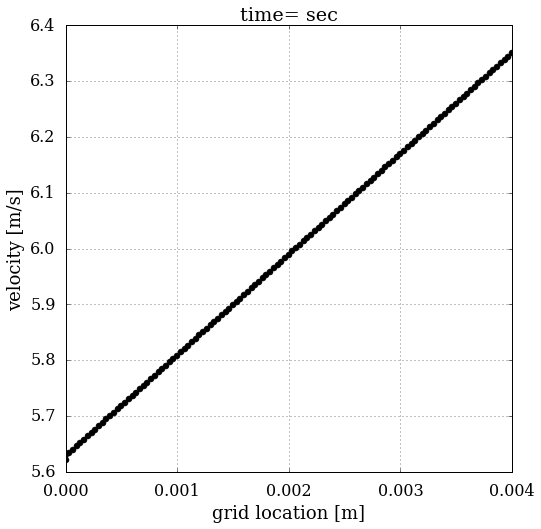

In [133]:
plot( xb,numpy.round(us[mid_time][1:-1], decimals=10), 'grid location [m]','velocity [m/s]',  'time= sec')

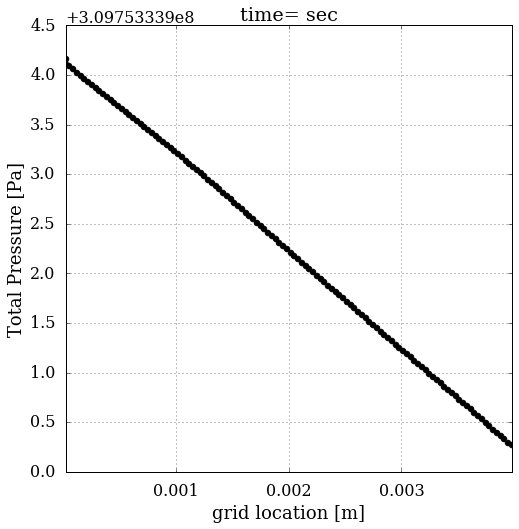

In [134]:
plot( xc,ps[mid_time][1:-1], 'grid location [m]','Total Pressure [Pa]',  'time= sec')

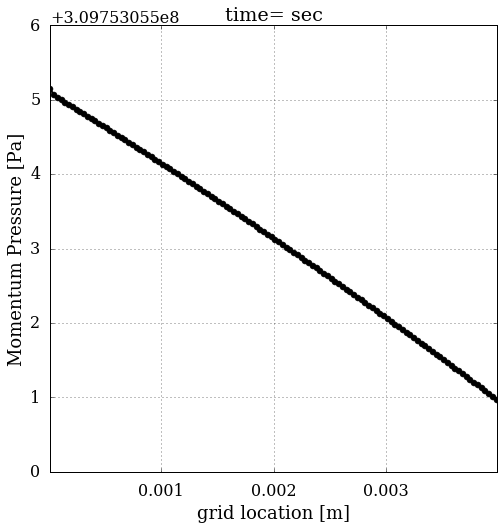

In [135]:
plot( xc,ps2[mid_time][1:-1], 'grid location [m]','Momentum Pressure [Pa]',  'time= sec')

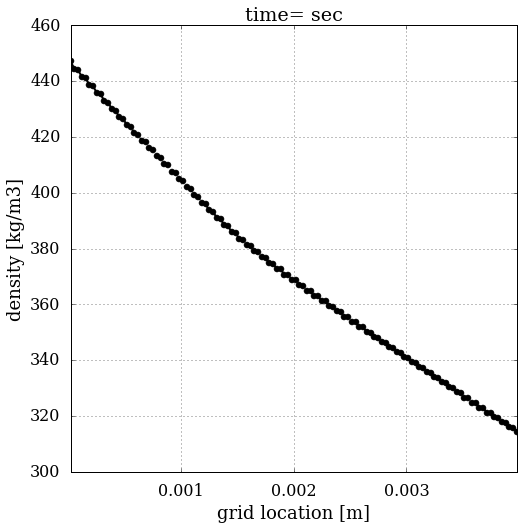

In [136]:
plot( xc,numpy.round(rhos[mid_time][1:-1],decimals=10), 'grid location [m]','density [kg/m3]',  'time= sec')

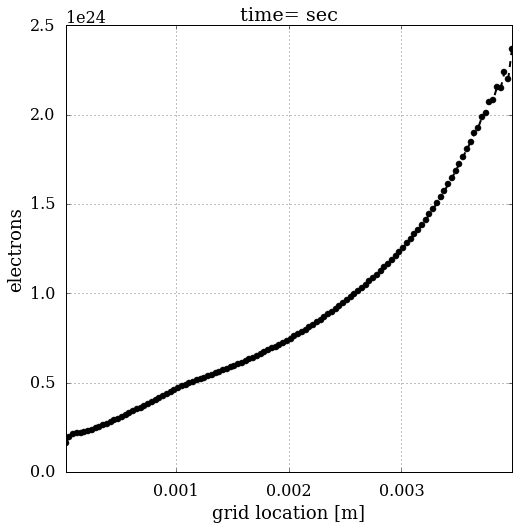

In [137]:
plot( xc,nes[mid_time][1:-1], 'grid location [m]','electrons',  'time= sec')

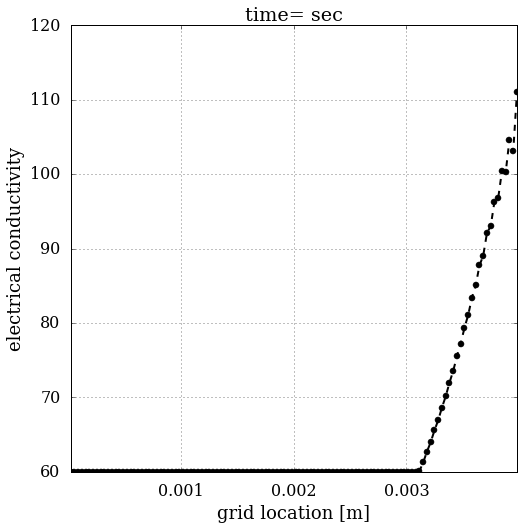

In [138]:
plot( xc,econds[mid_time][1:-1], 'grid location [m]','electrical conductivity',  'time= sec')

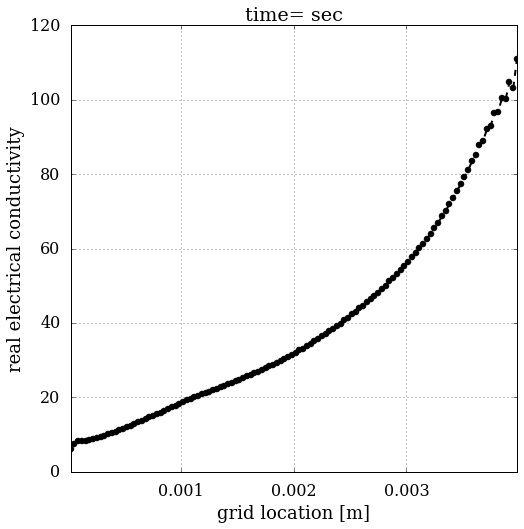

In [139]:
plot(xc,econdsreal[mid_time][1:-1], 'grid location [m]','real electrical conductivity',  'time= sec')

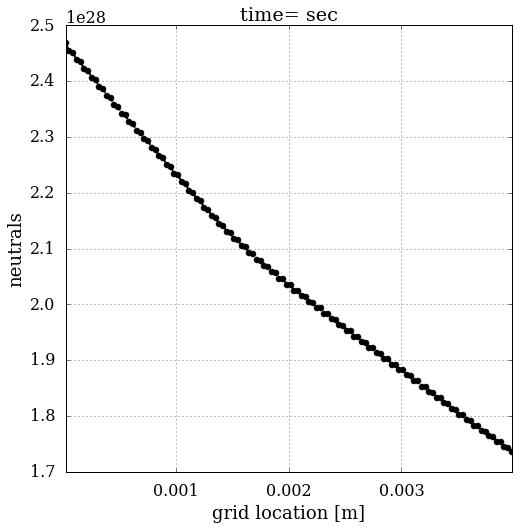

In [140]:
plot( xc, numpy.round(nos[mid_time][1:-1], decimals=25), 'grid location [m]','neutrals',  'time= sec')

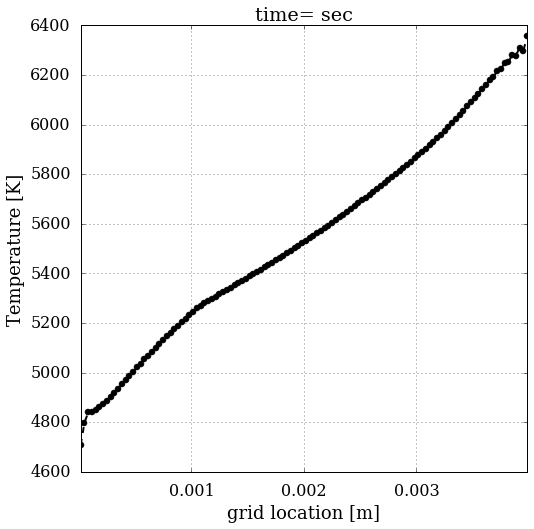

In [141]:
plot( xc,numpy.round(Ts[mid_time2][1:-1],decimals=10), 'grid location [m]','Temperature [K]',  'time= sec')

In [142]:
Ts[mid_time2]

array([ 4713.9516769 ,  4708.66813272,  4797.77831897,  4839.72312685,
        4841.35991294,  4848.8562346 ,  4860.32125424,  4872.61125628,
        4887.37662569,  4902.34332938,  4919.17213822,  4935.47281711,
        4953.0402297 ,  4969.59089836,  4987.14062613,  5003.45159752,
        5020.67484427,  5036.55643546,  5053.34488529,  5068.7430349 ,
        5085.07954336,  5099.99853484,  5115.90164461,  5130.36894844,
        5145.87452714,  5159.92967013,  5175.07975779,  5188.76324578,
        5203.59689881,  5216.94363858,  5231.49202834,  5244.52587174,
        5258.47618413,  5268.70142302,  5279.2526815 ,  5287.81259097,
        5297.74958002,  5306.13268107,  5315.98412406,  5324.26832364,
        5334.08989207,  5342.32025776,  5352.14950952,  5360.35580943,
        5370.22199356,  5378.43056786,  5388.35940815,  5396.59232187,
        5406.60688354,  5414.88522221,  5425.00835459,  5433.3523886 ,
        5443.60586243,  5452.03533185,  5462.44176684,  5470.97813001,
      

# final time

In [143]:
cfl[-1]

0.0008586166945057361

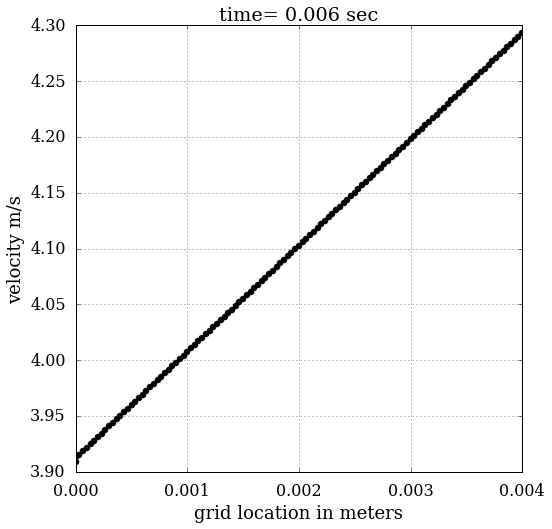

In [144]:
plot( xb,numpy.round(us[-1][1:-1],decimals=10), 'grid location in meters','velocity m/s',  'time= 0.006 sec')
#pyplot.savefig('velocity_006s.png')

In [145]:
ps[-1][1]

217780063.94694594

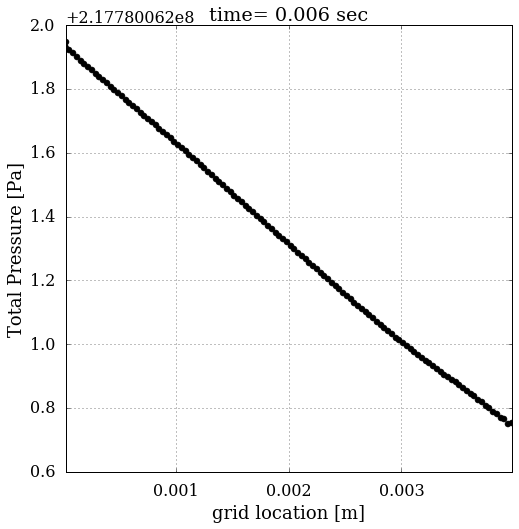

In [146]:
plot( xc,ps[-1][1:-1], 'grid location [m]','Total Pressure [Pa]',  'time= 0.006 sec')
#pyplot.savefig('totalpressure_006.png')

In [147]:
ps2[-1][1]

217780063.92917264

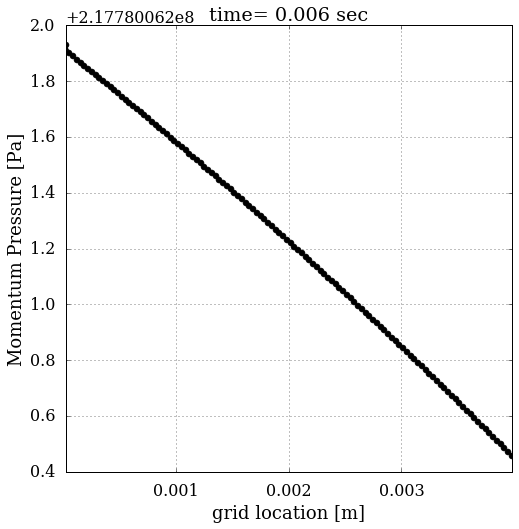

In [148]:
plot( xc,ps2[-1][1:-1], 'grid location [m]','Momentum Pressure [Pa]',  'time= 0.006 sec')
pyplot.savefig('heavypressure_006.png')

In [149]:
rhos[-1][0]

916.90115564806604

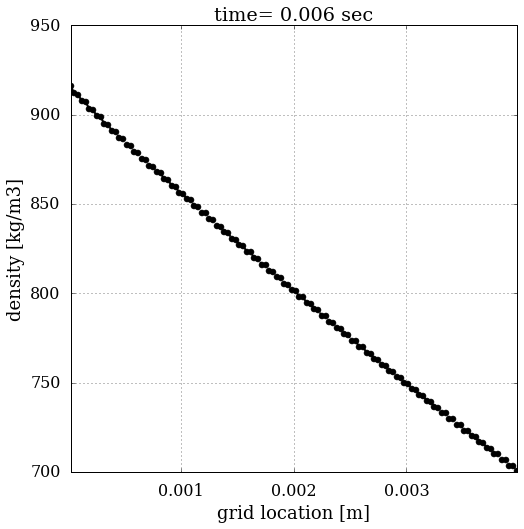

In [150]:
plot( xc,numpy.round(rhos[-1][1:-1], decimals=10), 'grid location [m]','density [kg/m3]',  'time= 0.006 sec')
pyplot.savefig('density_006.png')

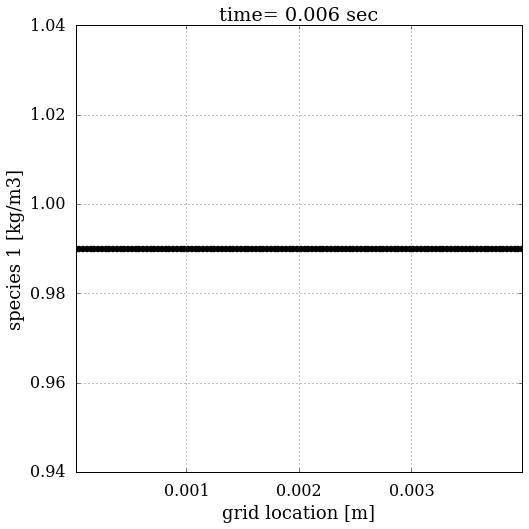

In [151]:
plot(xc,numpy.round(cBs[-1][1:-1], decimals=3), 'grid location [m]','species 1 [kg/m3]',  'time= 0.006 sec')
pyplot.savefig('boron_006.png')

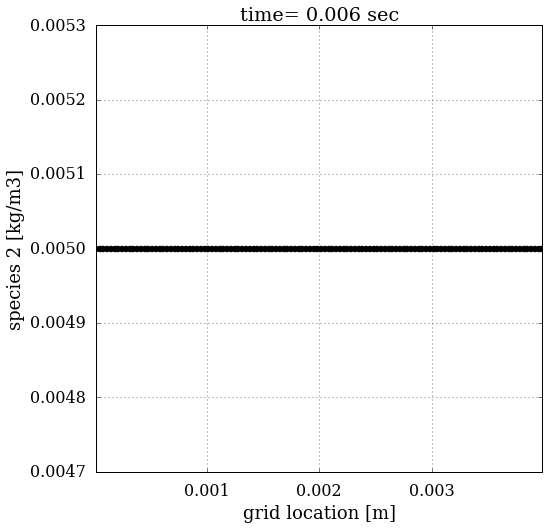

In [152]:
plot( xc,numpy.round(cNis[-1][1:-1], decimals=3), 'grid location [m]','species 2 [kg/m3]',  'time= 0.006 sec')
pyplot.savefig('nickel_006.png')

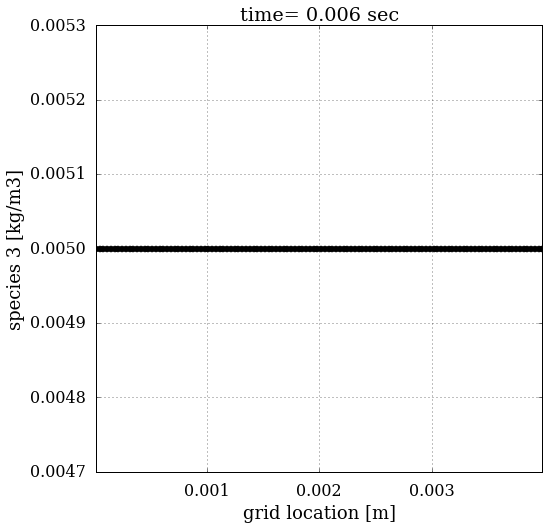

In [153]:
plot( xc,numpy.round(cCos[-1][1:-1], decimals=3), 'grid location [m]','species 3 [kg/m3]',  'time= 0.006 sec')
pyplot.savefig('cobalt_006.png')

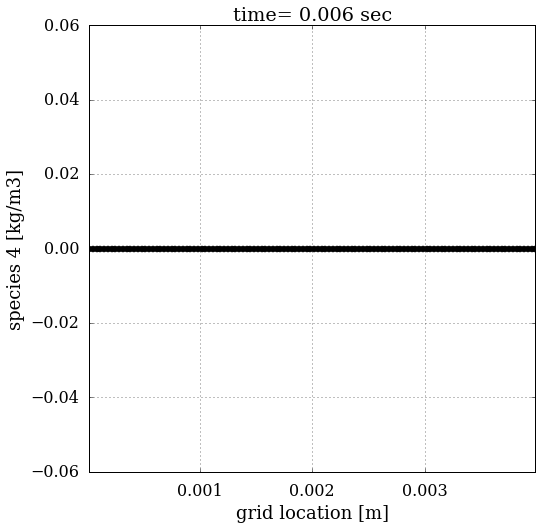

In [154]:
plot( xc,numpy.round(cNs[-1][1:-1], decimals=3), 'grid location [m]','species 4 [kg/m3]',  'time= 0.006 sec')
pyplot.savefig('nitrogen_006.png')

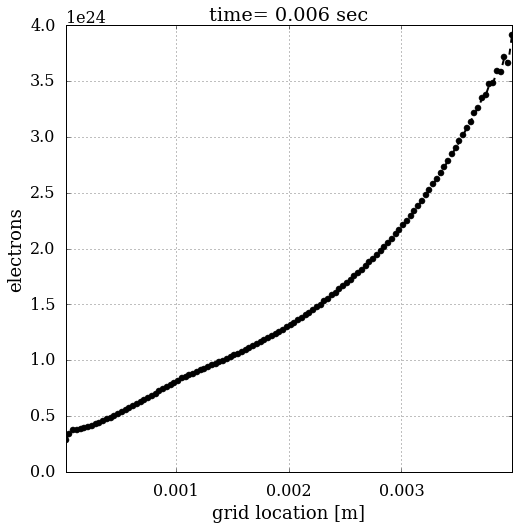

In [155]:
plot( xc,nes[-1][1:-1], 'grid location [m]','electrons',  'time= 0.006 sec')
pyplot.savefig('electrons_006.png')

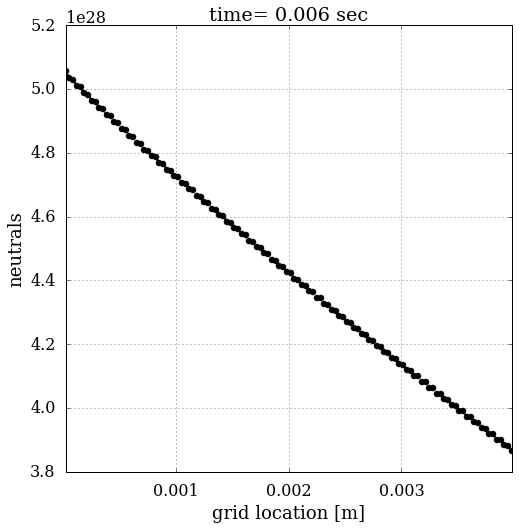

In [156]:
plot( xc, numpy.round(nos[-1][1:-1], decimals=25), 'grid location [m]','neutrals',  'time= 0.006 sec')
pyplot.savefig('neutrals_006.png')

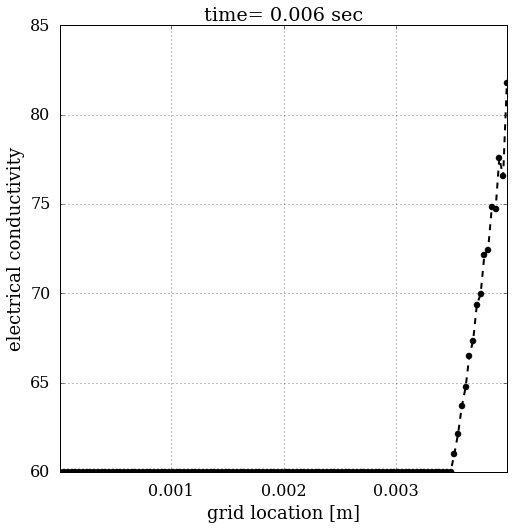

In [157]:
plot( xc,econds[-1][1:-1], 'grid location [m]','electrical conductivity',  'time= 0.006 sec')
pyplot.savefig('econd_006.png')

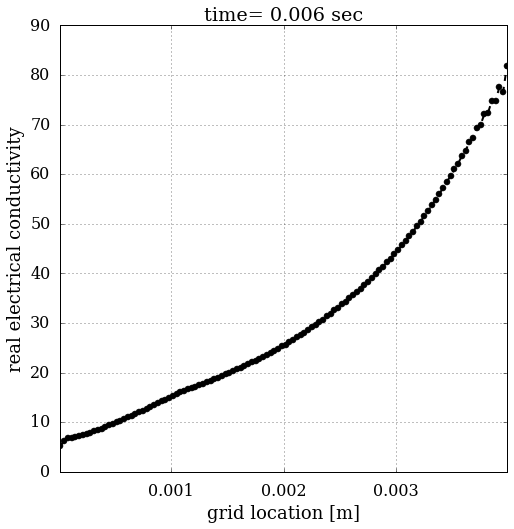

In [158]:
plot( xc,econdsreal[-1][1:-1], 'grid location [m]','real electrical conductivity',  'time= 0.006 sec')
pyplot.savefig('econdr_006.png')

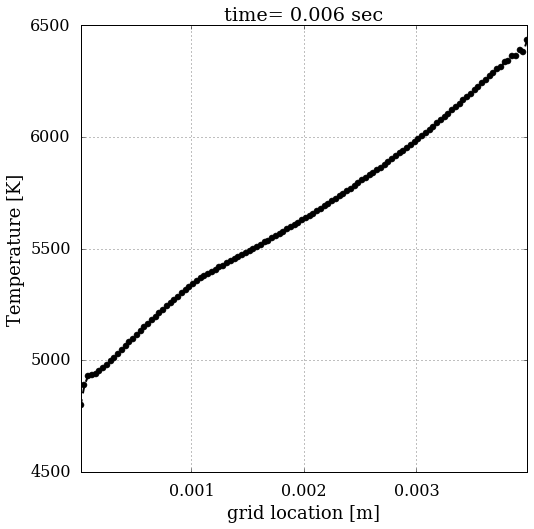

In [159]:
plot( xc,numpy.round(Ts[-1][1:-1],decimals=4), 'grid location [m]','Temperature [K]',  'time= 0.006 sec')
pyplot.savefig('temperature_006.png')

In [160]:
Ts[-1]

array([ 4803.20338578,  4798.55414479,  4888.08558436,  4930.13562023,
        4932.15387626,  4939.75516918,  4951.60447146,  4963.99917966,
        4979.15169625,  4994.22284644,  5011.44172627,  5027.84660159,
        5045.80708454,  5062.46171032,  5080.4075634 ,  5096.82225941,
        5114.44470082,  5130.4297854 ,  5147.62052079,  5163.12191842,
        5179.86380495,  5194.88579509,  5211.19737736,  5225.76741913,
        5241.68461242,  5255.84222046,  5271.40713257,  5285.19281182,
        5300.44456014,  5313.8932108 ,  5328.86301186,  5341.99850099,
        5356.37360421,  5366.70024626,  5377.67968666,  5386.34075083,
        5396.70935758,  5405.19333308,  5415.47986416,  5423.86462898,
        5434.12476701,  5442.45534377,  5452.72663846,  5461.03272836,
        5471.34438865,  5479.65228553,  5490.02999487,  5498.36169875,
        5508.82847459,  5517.20496773,  5527.78363425,  5536.22510706,
        5546.93742149,  5555.46354393,  5566.33213076,  5574.96431819,
      

### The graphs below address the issue of drastic variation in anode temperature. After some time, I noticed that  the anode temperature showed an usteady time dependency with oscillating values. To remedy, I chose to make the anode temperature the average of the domain when these variations begin to occur.

In [161]:
length = numpy.shape(ablrate)[0]
iterations_total = numpy.zeros((length))
Tanode = numpy.zeros((length))
#
for i in range(length):
    iterations_total[i] = i+1
    Tanode[i] = Ts[i][0]

In [162]:
numpy.shape(Ts)

(899852, 122)

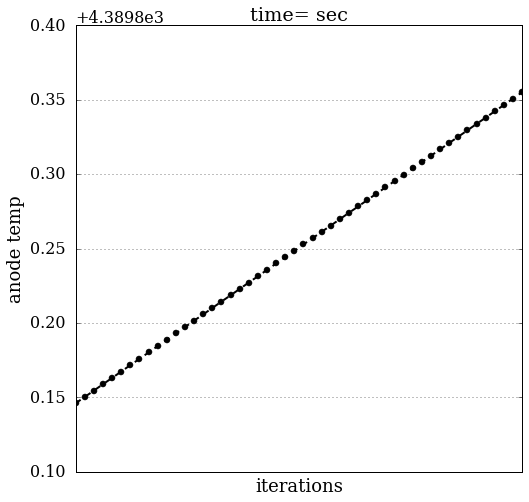

In [163]:
plot( iterations_total[1000:1050], numpy.round(Tanode[41100:41150],decimals=4), 'iterations','anode temp',  'time= sec')

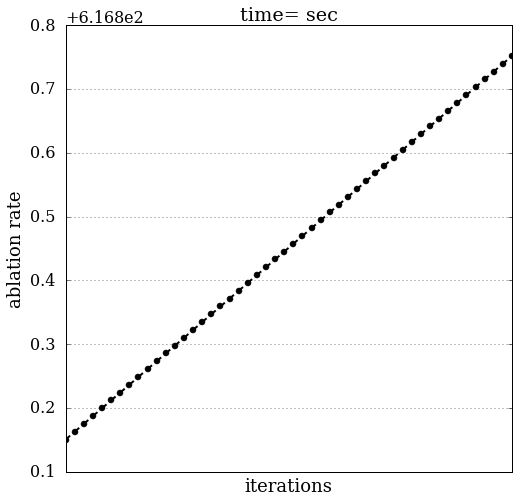

In [164]:
plot( iterations_total[1000:1050], numpy.round(ablrate[41100:41150],decimals=4), 'iterations','ablation rate',  'time= sec')

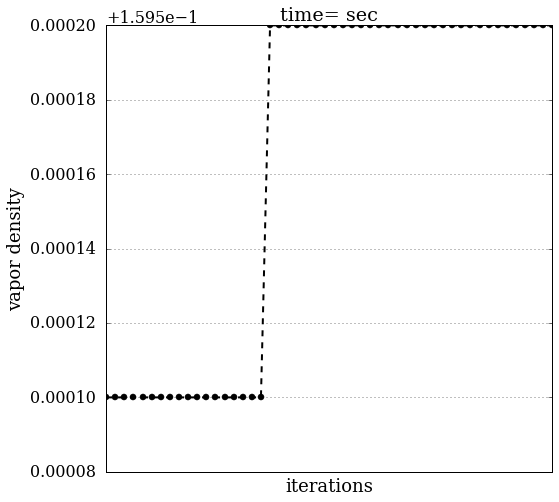

In [165]:
plot( iterations_total[1000:1050], numpy.round(rhos_vapor[41100:41150],decimals=4), 'iterations','vapor density',  'time= sec')

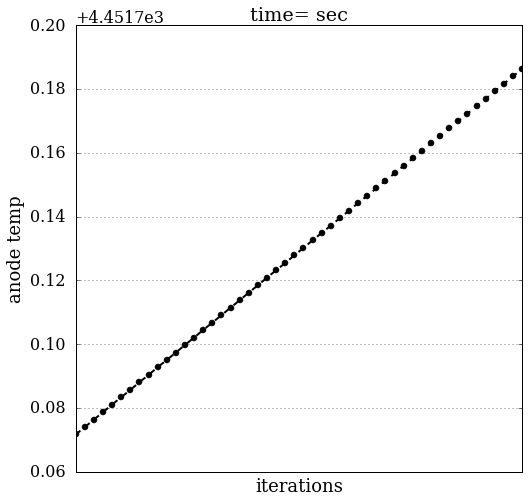

In [166]:
plot( iterations_total[1000:1050], numpy.round(Tanode[61100:61150],decimals=4), 'iterations','anode temp',  'time= sec')

### The anode temperature experiences a significant variation and i have minimized the noise by forcing the anode temperature to the average domain temperature whenever the temperature is lower than the previous anode temperature. This helps keep the ablation rate steady.

In [167]:
numpy.average(Ts[-1]-Ts[-2])

0.00015974874531075628

In [168]:
numpy.average(rhos[-1]-rhos[-2])

0.00096519826566229133

In [169]:
numpy.abs(numpy.average(us[-1]-us[-2]))

2.7711578187380811e-06

## Animation

In [170]:
numpy.shape(ctime)

(899851,)

In [171]:
numpy.shape(ps)

(899852, 122)

In [172]:
time_domain = numpy.size(ctime)
time_domain_temp = numpy.shape(Ts)[0]
# time_domain_pressure = numpy.shape(ps)[0]
space_domain = numpy.size(xb)
space_domain2 = numpy.size(xc)
US = numpy.zeros((time_domain, space_domain), dtype=float)
TS = numpy.zeros((time_domain_temp, space_domain2), dtype=float)
PS = numpy.zeros((time_domain_temp, space_domain2), dtype=float)
JS = numpy.zeros((time_domain, space_domain2), dtype=float)
NES = numpy.zeros((time_domain, space_domain2), dtype=float)
RHOS = numpy.zeros((time_domain, space_domain2), dtype=float)
C1S = numpy.zeros((time_domain, space_domain2), dtype=float)
C2S = numpy.zeros((time_domain, space_domain2), dtype=float)
C3S = numpy.zeros((time_domain, space_domain2), dtype=float)
C4S = numpy.zeros((time_domain, space_domain2), dtype=float)
ECONDRS =  numpy.zeros((time_domain, space_domain2), dtype=float)
ECOND =  numpy.zeros((time_domain, space_domain2), dtype=float)
#
for i in range(time_domain):
    US[i,:] = us[i][1:-1]
    NES[i,:] = nes[i][1:-1]
    RHOS[i,:] = rhos[i][1:-1]
    ECONDRS[i,:] = econdsreal[i][1:-1]
    ECOND[i,:] = econds[i][1:-1]
    C1S[i,:] = cBs[i][1:-1]
    C2S[i,:] = cNis[i][1:-1]
    C3S[i,:] = cCos[i][1:-1]
    C4S[i,:] = cNs[i][1:-1]
    #
for i in range(time_domain_temp):
    TS[i,:] = Ts[i][1:-1]
    PS[i,:] = ps[i][1:-1]

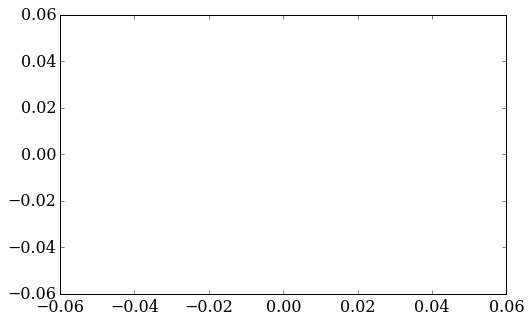

In [194]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes()
im = ax.plot([], [], color='b', ls='--', lw=3)

In [174]:
def animate(data):
    im = ax.plot(xb,data, color='b', ls='--', lw=3)
    return im

In [175]:
def animate2(data):
    im = ax.plot(xc,data, color='b', ls='--', lw=3)
    return im

In [195]:
anim = animation.FuncAnimation(fig, animate2, frames=C1S[1::500,:], interval=200)

In [196]:
#anim.save("1D_ABL_Us.mp4", writer='ffmpeg')

#anim.save("1D_ABL_rho.mp4", writer='ffmpeg')
#anim.save("1D_ABL_Ts.mp4", writer='ffmpeg')
#anim.save("1D_ABL_ps.mp4", writer='ffmpeg')
#anim.save("1D_ABL_NES.mp4", writer='ffmpeg')

#anim.save("1D_ABL_econd.mp4", writer='ffmpeg')
#anim.save("1D_ABL_econdrs.mp4", writer='ffmpeg')
anim.save("1D_ABL_c1.mp4", writer='ffmpeg')
#anim.save("1D_ABL_c2.mp4", writer='ffmpeg')
#anim.save("1D_ABL_c3.mp4", writer='ffmpeg')
#anim.save("1D_ABL_c4.mp4", writer='ffmpeg')
#anim.save("1D_ABL_js.mp4", writer='ffmpeg')

#display_animation(anim, default_mode='once')

In [ ]:
capacitor = 10*1e-6
resistor1 = 47e3
resistor2 = 100e3
fhz = 1/(numpy.log(2)*capacitor*(resistor1+2*resistor2))
hightime = numpy.log(2)*capacitor*(resistor1+resistor2)
lowtime = numpy.log(2)*capacitor*resistor2

In [ ]:
fhz


In [ ]:
hightime

In [ ]:
lowtime